## Setting Up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
from scipy.spatial.distance import cdist
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GroupKFold, KFold, train_test_split, GroupShuffleSplit
from calendar import month_abbr

import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
from oggm import cfg, utils, workflow, tasks
import logging
import geopandas as gpd
import xarray as xr

import config
import massbalancemachine as mbm

from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.plots import *
from scripts.xgb_helpers import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [2]:
seed_all(config.SEED)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

cmap = cm.devon
color_palette_glaciers = sns.color_palette(get_cmap_hex(cmap, 15))

# For bars and lines:
# color_diff_xgb = '#878787'
color_diff_xgb = '#4d4d4d'

colors = get_cmap_hex(cm.batlow, 10)
color_xgb = colors[0]
color_tim = '#c51b7d'

color_winter = '#a6cee3'
color_annual = '#1f78b4'

# Violin and boxplots:
colors_temp_freq = sns.color_palette(get_cmap_hex(cm.devon, 8))
boxplot_style = {
    "width": .6,
    "showcaps": False,
    "palette": colors_temp_freq,
    "flierprops": {
        "marker": "x"
    },
    "showmeans": True,
    "meanprops": {
        "markerfacecolor": "white"
    }
}

marker_tim = 's'
marker_xgb = 'o'
marker_std = '_'

custom_working_dir = '../../../data/OGGM/'

In [3]:
# RGI Ids:
# Read rgi ids:
path_rgi = '../../../data/GLAMOS/CH_glacier_ids_long.csv'
rgi_df = pd.read_csv(path_rgi, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('short_name', inplace=True)

In [4]:
# Specify the short names of the climate variables available in the dataset
vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]
# vois_topographical = [
#     "aspect", "slope", "dis_from_border", "hugonnet_dhdt",
#     "consensus_ice_thickness", "millan_ice_thickness", "millan_v", "millan_vx",
#     "millan_vy", #"snowslide_1m"
# ]

vois_topographical = [
    "aspect",
    "slope",
    # "dis_from_border",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

DF_TYPE = 'all'

## Read GL data:

In [5]:
# Read stakes data over all glaciers:
data_glamos = pd.read_csv(path_PMB_GLAMOS_csv +
                          f'CH_wgms_dataset_{DF_TYPE}.csv')

print('Number of glaciers:', len(data_glamos['GLACIER'].unique()))

# Capitalize glacier names:
glacierCap = {}
for gl in data_glamos['GLACIER'].unique():
    if gl == 'claridenU':
        glacierCap[gl] = 'Clariden_U'
    elif gl == 'claridenL':
        glacierCap[gl] = 'Clariden_L'
    else:
        glacierCap[gl] = gl.capitalize()

data_glamos.head(2)

Number of glaciers: 43


YEAR  POINT_ID GLACIER  FROM_DATE   TO_DATE  POINT_LAT  POINT_LON  \
0  2006  adler_28   adler   20051017  20061011  46.010637   7.855896   
1  2006  adler_55   adler   20051017  20061011  46.010052   7.858628   

   POINT_ELEVATION  POINT_BALANCE  PERIOD  ...     slope  dis_from_border  \
0      3096.507742         -2.592  annual  ...  0.340053            120.0   
1      3141.506520         -2.502  annual  ...  0.219036             30.0   

     topo  hugonnet_dhdt  consensus_ice_thickness  millan_ice_thickness  \
0  3039.0      -1.504815                43.181839             37.110600   
1  3091.0      -0.970061                41.090096              8.961324   

   millan_v  millan_vx  millan_vy  snowslide_1m  
0  3.591626   3.445628   1.013618           1.0  
1  0.975349  -0.948907  -0.058481           1.0  

[2 rows x 22 columns]

### All glaciers:

Text(0.5, 1.0, 'Number of total measurements per glacier since 1951')

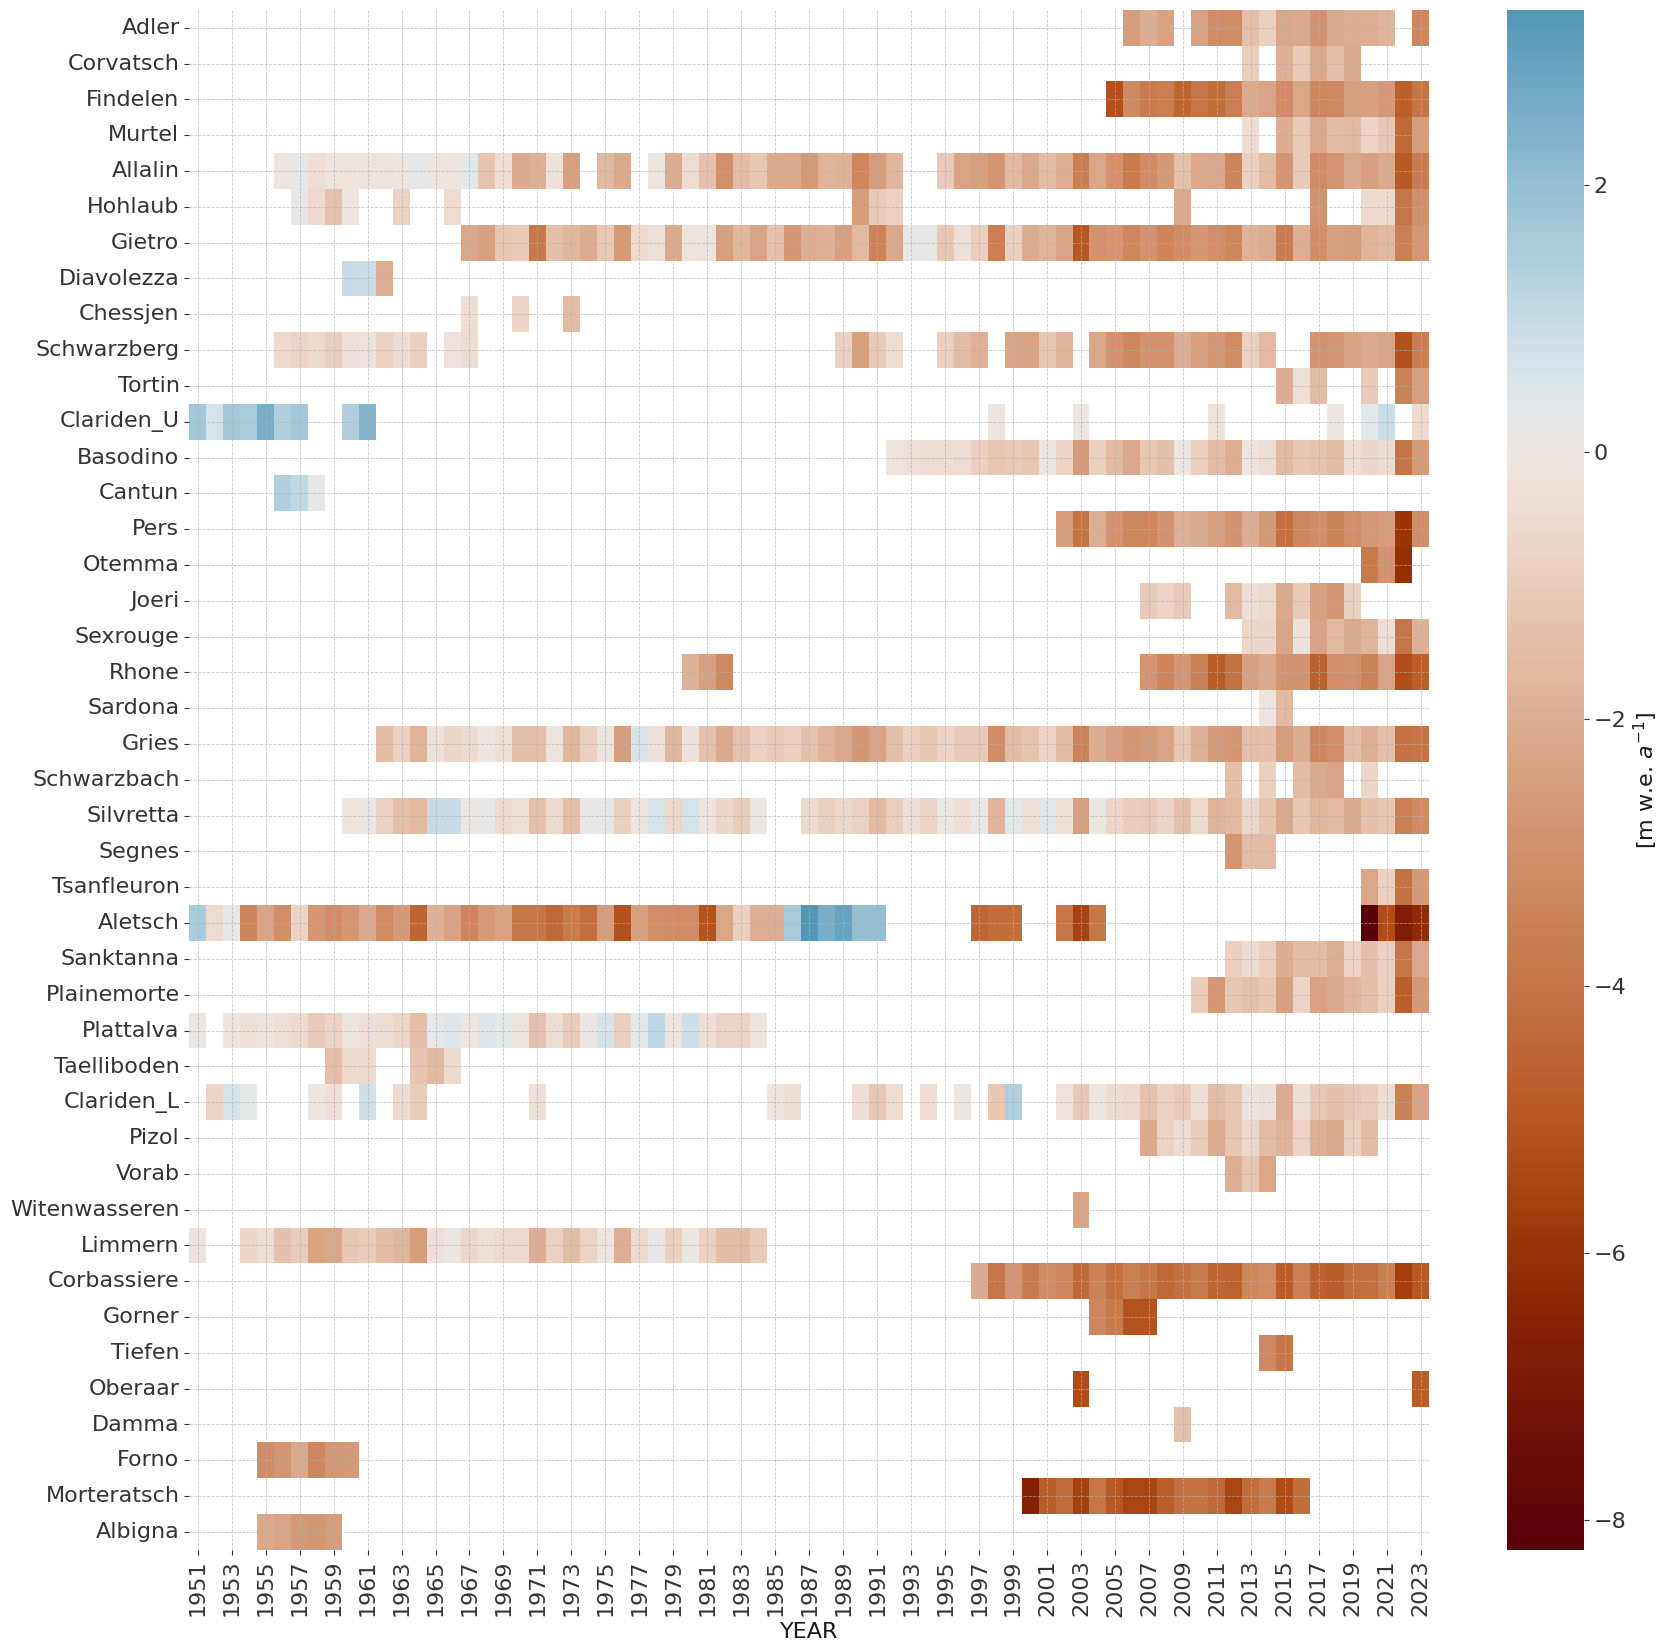

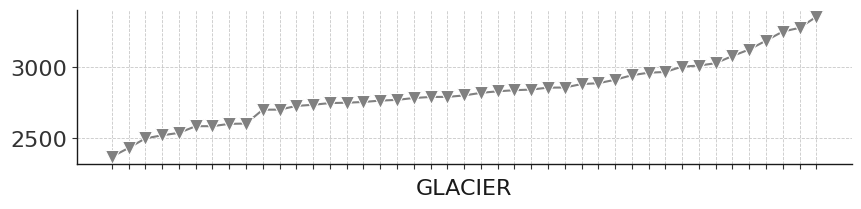

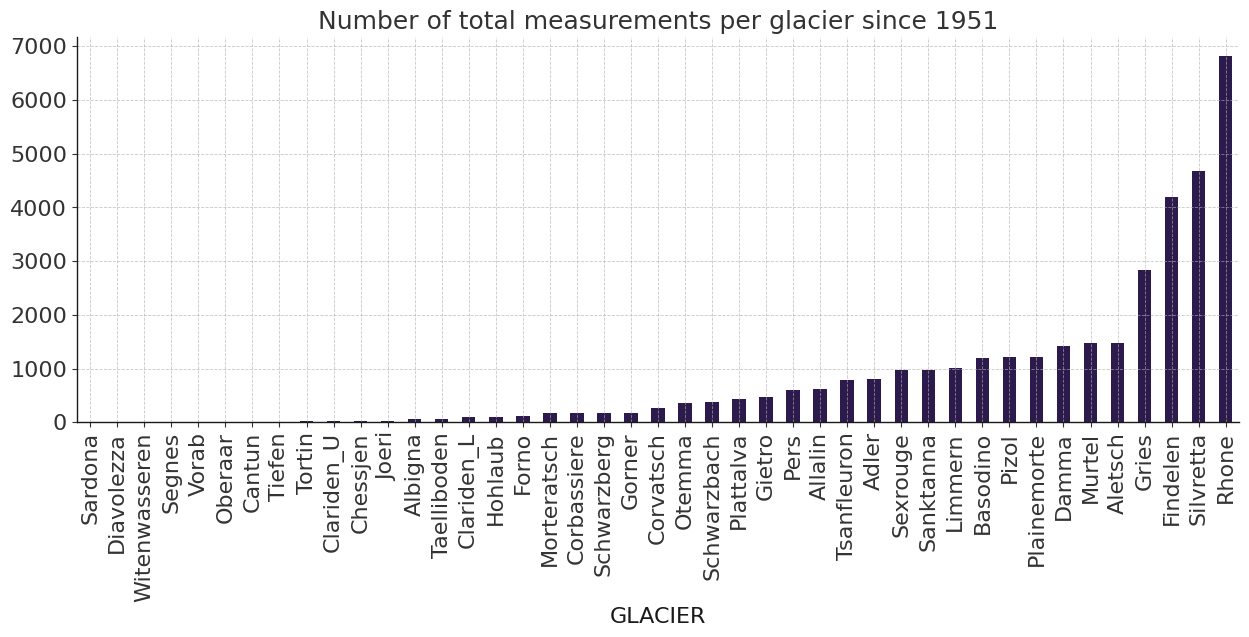

In [6]:
# Heatmap of mean mass balance per glacier:
# Get the mean mass balance per glacier
data_glamos_ = data_glamos.copy()
data_glamos_['GLACIER'] = data_glamos.GLACIER.apply(lambda x: glacierCap[x])
mean_mb_per_glacier = data_glamos_.groupby(
    ['GLACIER', 'YEAR', 'PERIOD'])['POINT_BALANCE'].mean().reset_index()
mean_mb_per_glacier = mean_mb_per_glacier[mean_mb_per_glacier['PERIOD'] ==
                                          'annual']

matrix = mean_mb_per_glacier.pivot(
    index='GLACIER', columns='YEAR',
    values='POINT_BALANCE').sort_values(by='GLACIER')

# get elevation of glaciers:
gl_per_el = data_glamos_.groupby(['GLACIER'])['POINT_ELEVATION'].mean()
gl_per_el = gl_per_el.sort_values(ascending=False)
matrix = matrix.loc[gl_per_el.index]

# make index categorical
matrix.index = pd.Categorical(matrix.index,
                              categories=matrix.index,
                              ordered=True)
fig = plt.figure(figsize=(20, 20))
ax = plt.subplot(1, 1, 1)
sns.heatmap(data=matrix,
            center=0,
            cmap=cm.vik_r,
            cbar_kws={'label': '[m w.e. $a^{-1}$]'},
            ax=ax)

# Plot elevation:
fig = plt.figure(figsize=(10, 2))
ax = plt.subplot(1, 1, 1)
sns.lineplot(gl_per_el.sort_values(ascending=True),
             ax=ax,
             color='gray',
             marker='v')
ax.set_xticklabels('', rotation=90)
ax.set_ylabel('')

fig = plt.figure(figsize=(10, 2))
num_gl = data_glamos_.groupby(['GLACIER']).size().sort_values()
num_gl.plot(kind='bar', figsize=(15, 5), cmap=cmap)
plt.title('Number of total measurements per glacier since 1951')


### Glaciers with pot. radiadation data:

In [7]:
# Glaciers with data of potential clear sky radiation
# Format to same names as stakes:
glDirect = [
    re.search(r'xr_direct_(.*?)\.nc', f).group(1)
    for f in os.listdir(path_direct_save)
]
glDirect.sort()

restgl = Diff(list(glDirect), list(data_glamos.GLACIER.unique()))
restgl.sort()
print('Glaciers with potential clear sky radiation data:\n', glDirect)
print('Glaciers without potential clear sky radiation data:\n', restgl)

# Filter out glaciers without data:
data_glamos = data_glamos[data_glamos.GLACIER.isin(glDirect)]

Glaciers with potential clear sky radiation data:
 ['adler', 'albigna', 'aletsch', 'allalin', 'arolla', 'basodino', 'claridenL', 'claridenU', 'corbassiere', 'corvatsch', 'findelen', 'forno', 'gietro', 'gorner', 'gries', 'hohlaub', 'joeri', 'limmern', 'morteratsch', 'murtel', 'oberaar', 'otemma', 'pers', 'pizol', 'plainemorte', 'plattalva', 'rhone', 'sanktanna', 'schwarzbach', 'schwarzberg', 'sexrouge', 'silvretta', 'taelliboden', 'tortin', 'tsanfleuron']
Glaciers without potential clear sky radiation data:
 ['arolla', 'cantun', 'chessjen', 'damma', 'diavolezza', 'sardona', 'segnes', 'tiefen', 'vorab', 'witenwasseren']


In [8]:
# Look at the data of the ERA5 dataset:
xr.open_dataset(path_ERA5_raw + 'era5_monthly_averaged_data.nc')

<xarray.Dataset> Size: 2GB
Dimensions:    (longitude: 201, latitude: 51, expver: 2, time: 895)
Coordinates:
  * longitude  (longitude) float32 804B 0.0 0.1 0.2 0.3 ... 19.7 19.8 19.9 20.0
  * latitude   (latitude) float32 204B 50.0 49.9 49.8 49.7 ... 45.2 45.1 45.0
  * expver     (expver) int32 8B 1 5
  * time       (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2024-07-01
Data variables: (12/14)
    u10        (time, expver, latitude, longitude) float64 147MB ...
    v10        (time, expver, latitude, longitude) float64 147MB ...
    t2m        (time, expver, latitude, longitude) float64 147MB ...
    fal        (time, expver, latitude, longitude) float64 147MB ...
    snowc      (time, expver, latitude, longitude) float64 147MB ...
    rsn        (time, expver, latitude, longitude) float64 147MB ...
    ...         ...
    smlt       (time, expver, latitude, longitude) float64 147MB ...
    slhf       (time, expver, latitude, longitude) float64 147MB ...
    str        (time, expver, latitude, longitude) float64 147MB ...
    sshf       (time, expver, latitude, longitude) float64 147MB ...
    ssrd       (time, expver, latitude, longitude) float64 147MB ...
    tp         (time, expver, latitude, longitude) float64 147MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-08-08 11:30:10 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

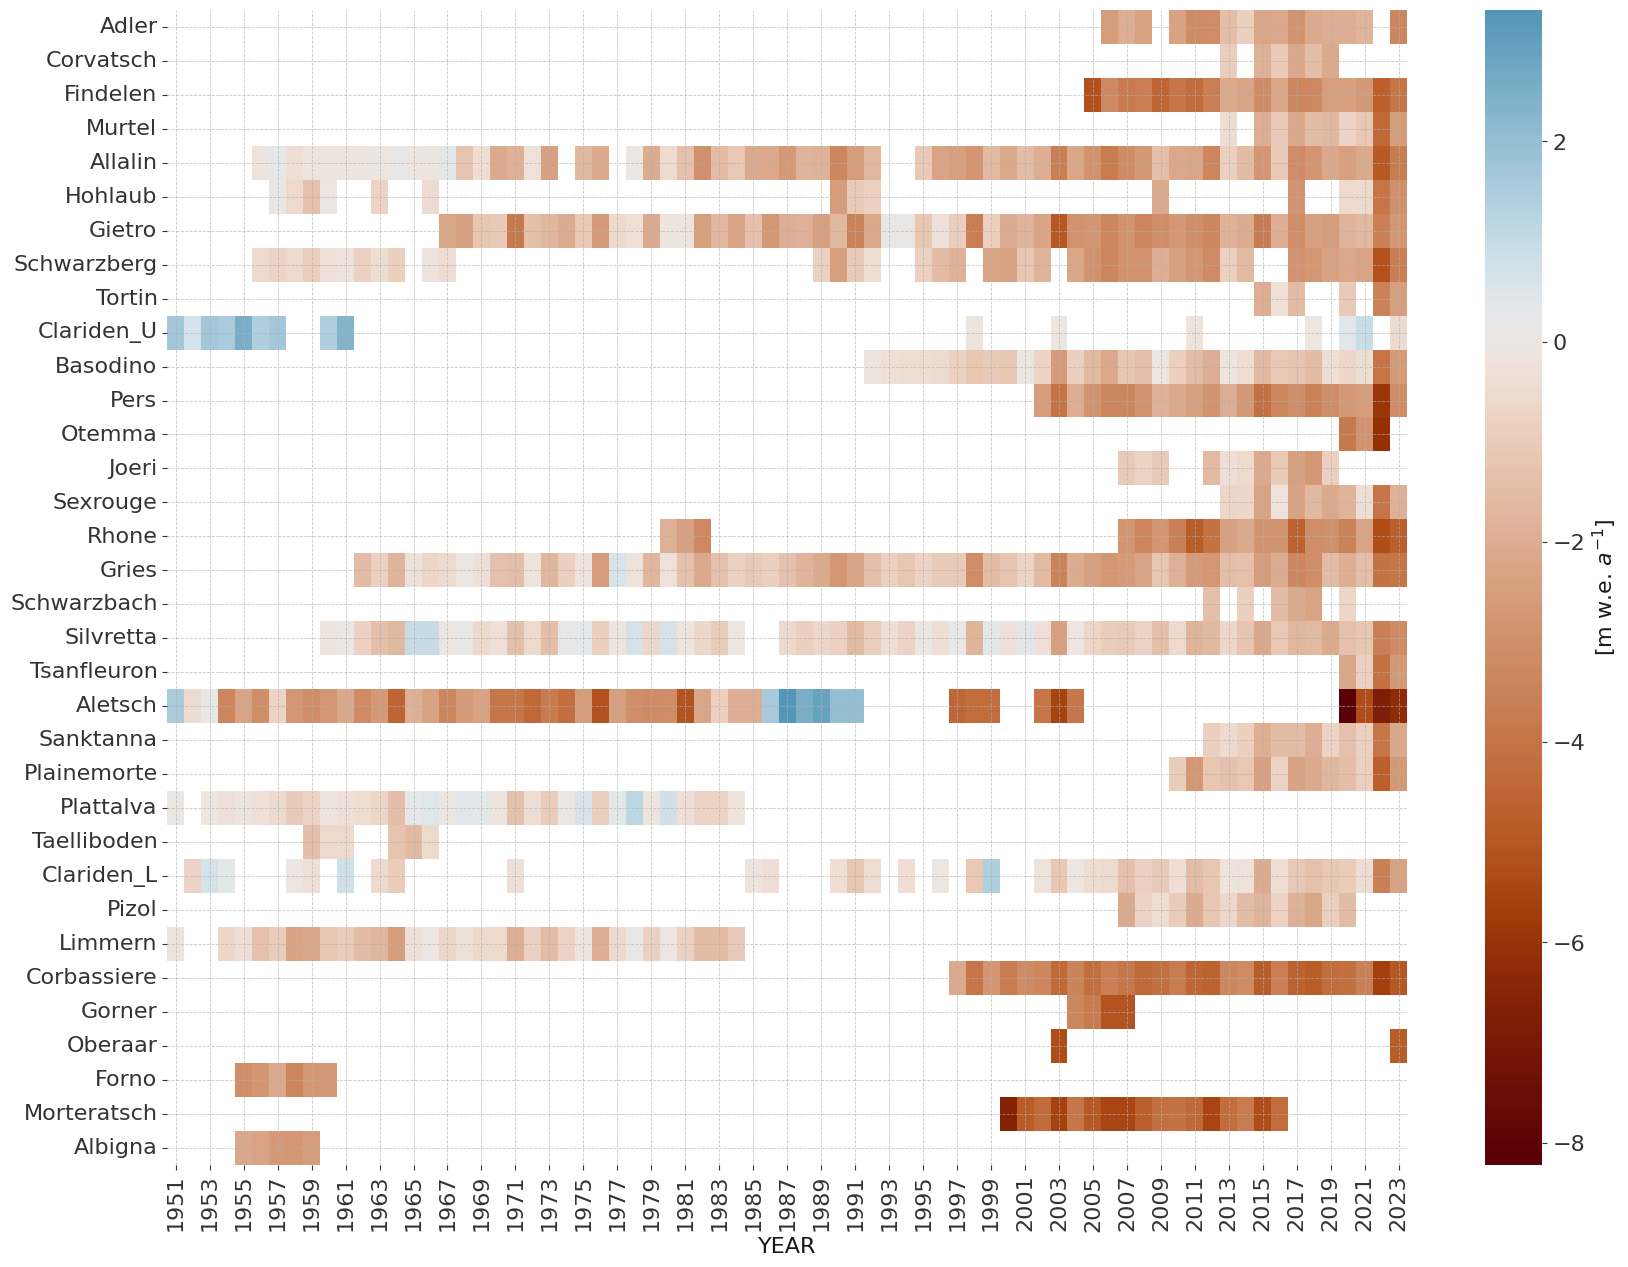

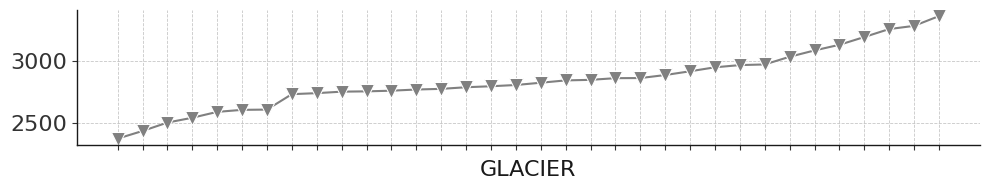

In [9]:
# Heatmap of mean mass balance per glacier:
# Get the mean mass balance per glacier
data_glamos_ = data_glamos.copy()
data_glamos_['GLACIER'] = data_glamos['GLACIER'].apply(lambda x: glacierCap[x])

mean_mb_per_glacier = data_glamos_.groupby(
    ['GLACIER', 'YEAR', 'PERIOD'])['POINT_BALANCE'].mean().reset_index()
mean_mb_per_glacier = mean_mb_per_glacier[mean_mb_per_glacier['PERIOD'] ==
                                          'annual']

matrix = mean_mb_per_glacier.pivot(
    index='GLACIER', columns='YEAR',
    values='POINT_BALANCE').sort_values(by='GLACIER')

# get elevation of glaciers:
gl_per_el = data_glamos_.groupby(['GLACIER'])['POINT_ELEVATION'].mean()
gl_per_el = gl_per_el.sort_values(ascending=False)

# Order matrix:
matrix = matrix.loc[gl_per_el.index]
matrix.index = pd.Categorical(matrix.index,
                              categories=matrix.index,
                              ordered=True)

# Plot heatmap:
fig = plt.figure(figsize=(20, 15))
ax = plt.subplot(1, 1, 1)
heatmap = sns.heatmap(
    data=matrix,
    center=0,
    cmap=cm.vik_r,
    cbar_kws={'label': '[m w.e. $a^{-1}$]'},
    ax=ax,
)

# Plot elevation:
fig = plt.figure(figsize=(10, 2))
ax = plt.subplot(1, 1, 1)
sns.lineplot(gl_per_el.sort_values(ascending=True),
             ax=ax,
             color='gray',
             marker='v')
ax.set_xticklabels('', rotation=90)
ax.set_ylabel('')
plt.tight_layout()


## Input data:
### Input dataset:

In [10]:
RUN = False
if RUN:
    # Filter data_glamos
    print('Running on {} glaciers:\n {}'.format(
        len(data_glamos.GLACIER.unique()), data_glamos.GLACIER.unique()))
    # Create dataloader:
    dataset_gl = mbm.Dataset(data=data_glamos,
                             region_name='CH',
                             data_path=path_PMB_GLAMOS_csv)
    print('Number of winter and annual samples:', len(data_glamos))
    print('Number of annual samples:',
          len(data_glamos[data_glamos.PERIOD == 'annual']))
    print('Number of winter samples:',
          len(data_glamos[data_glamos.PERIOD == 'winter']))

    # Add climate data:
    # Specify the files of the climate data, that will be matched with the coordinates of the stake data
    era5_climate_data = path_ERA5_raw + 'era5_monthly_averaged_data.nc'
    geopotential_data = path_ERA5_raw + 'era5_geopotential_pressure.nc'

    # Match the climate features, from the ERA5Land netCDF file, for each of the stake measurement dataset
    dataset_gl.get_climate_features(climate_data=era5_climate_data,
                                    geopotential_data=geopotential_data,
                                    change_units=True)

    # Add potential clear sky radiation:
    print('----------------------\nAdding potential clear sky radiation:')
    print('Shape before pot rad:', dataset_gl.data.shape)
    dataset_gl.get_potential_rad(path_direct_save)
    print('Shape after pot rad:', dataset_gl.data.shape)

    print('----------------------\nConverting to monthly resolution:')
    # For each record, convert to a monthly time resolution
    dataset_gl.convert_to_monthly(meta_data_columns=config.META_DATA,
                                  vois_climate=vois_climate + ['pcsr'],
                                  vois_topographical=vois_topographical)

    # Create a new DataLoader object with the monthly stake data measurements.
    dataloader_gl = mbm.DataLoader(data=dataset_gl.data,
                                   random_seed=config.SEED,
                                   meta_data_columns=config.META_DATA)

    print('Number of monthly rows:', len(dataloader_gl.data))
    print('Columns in the dataset:', dataloader_gl.data.columns)

    # save the data
    dataloader_gl.data.to_csv(path_PMB_GLAMOS_csv +
                              'CH_wgms_dataset_monthly_full.csv',
                              index=False)
else:
    # read data
    data_monthly = pd.read_csv(path_PMB_GLAMOS_csv +
                               'CH_wgms_dataset_monthly_full.csv')
    dataloader_gl = mbm.DataLoader(data=data_monthly,
                                   random_seed=config.SEED,
                                   meta_data_columns=config.META_DATA)
    print('Number of monthly rows:', len(dataloader_gl.data))
    print('Number of annual rows:',
          len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual']))
    print('Number of winter rows:',
          len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter']))

Number of monthly rows: 300905
Number of annual rows: 102252
Number of winter rows: 198653


In [11]:
data_monthly.head(2)

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  2006   7.855896  46.010637         -2.592       2787.508638   
1  2006   7.855896  46.010637         -2.592       2787.508638   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  POINT_ID  ID  ...  \
0            308.999104      3096.507742  RGI60-11.02764  adler_28   0  ...   
1            308.999104      3096.507742  RGI60-11.02764  adler_28   0  ...   

         t2m        tp           slhf           sshf          ssrd       fal  \
0  -7.534975  0.001175 -176999.405490 -243462.317031  7.256997e+06  0.678897   
1 -14.348139  0.002283   31280.688874  217670.830543  5.847847e+06  0.818081   

            str       u10       v10       pcsr  
0 -2.764534e+06  0.548619  0.054795  59.683667  
1 -1.811733e+06  1.031728 -0.189422  35.583250  

[2 rows x 29 columns]

### Correction for elevation difference:

In [12]:
path_glogem_factors = os.path.join(path_glogem, 'reference_run_GloGEM2024.csv')
glogem_factors = pd.read_csv(path_glogem_factors)
glogem_factors = glogem_factors.rename(columns={'ID': 'RGIId'})


def format_rgi_code(X):
    # Convert X to a string, and pad with leading zeros if its length is less than 5
    Y = str(X).zfill(5)
    # Return the final formatted string
    return f"RGI60-11.{Y}"


glogem_factors['RGIId'] = glogem_factors['RGIId'].apply(
    lambda x: format_rgi_code(x))

c_prec, t_off = {}, {}
for gl in data_monthly.GLACIER.unique():
    rgi_gl = data_monthly[data_monthly.GLACIER == gl].RGIId.unique()[0]
    factor_gl = glogem_factors[glogem_factors.RGIId == rgi_gl]
    c_prec[gl] = factor_gl['Cprec'].values[0]
    t_off[gl] = factor_gl['T_off'].values[0]

# Correct t2m and tp for elevation
data_monthly = correctTP(data_monthly, c_prec, t_off)

# Save with corrected values:
dataloader_gl = mbm.DataLoader(data=data_monthly,
                               random_seed=config.SEED,
                               meta_data_columns=config.META_DATA)

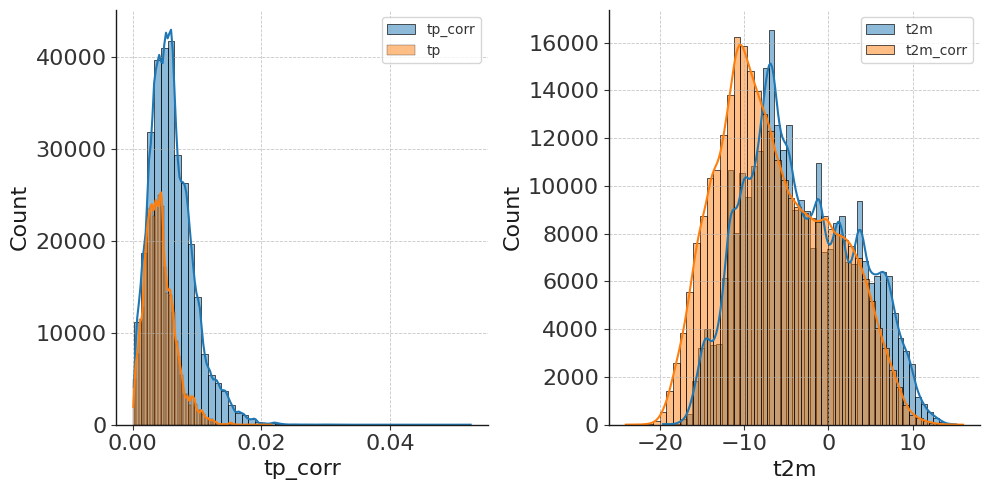

In [13]:
# Plot the distribution of the corrected precipitation:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
sns.histplot(data_monthly['tp_corr'],
             bins=50,
             kde=True,
             label='tp_corr',
             alpha=0.5,
             ax=ax)
sns.histplot(data_monthly['tp'],
             bins=50,
             kde=True,
             label='tp',
             alpha=0.5,
             ax=ax)
ax.legend()

ax = plt.subplot(1, 2, 2)
sns.histplot(data_monthly['t2m'],
             bins=50,
             kde=True,
             label='t2m',
             alpha=0.5,
             ax=ax)
sns.histplot(data_monthly['t2m_corr'],
             bins=50,
             kde=True,
             label='t2m_corr',
             alpha=0.5,
             ax=ax)
ax.legend()

plt.tight_layout()

### Feature correlation:

<Axes: >

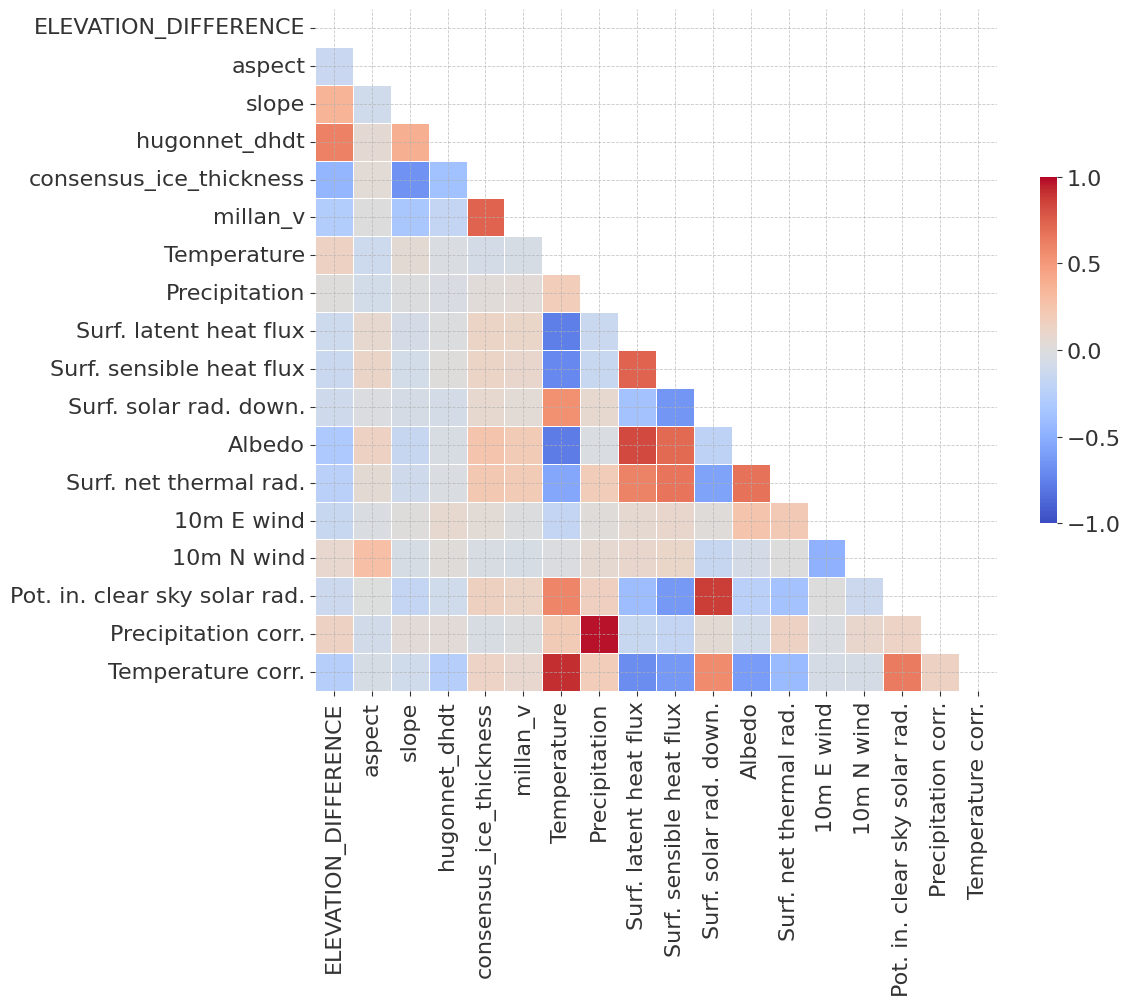

In [14]:
# Intercorrelation between features:
df = dataloader_gl.data.copy()
df = df.dropna()
df = df.drop(columns=[
    'GLACIER',
    'PERIOD',
    'YEAR',
    'POINT_LON',
    'POINT_LAT',
    'POINT_BALANCE',
    'ALTITUDE_CLIMATE',
    'POINT_ELEVATION',
    'RGIId',
    'POINT_ID',
    'ID',
    'N_MONTHS',
    'MONTHS',
])
# rename voi climate to long name
df.rename(columns=vois_climate_long_name, inplace=True)

corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# plot
sns.heatmap(corr,
            mask=mask,
            cmap='coolwarm',
            vmax=1,
            vmin=-1,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5})

### Num. meas per year:

Text(0.5, 1.0, 'Number of measurements per year for all glaciers')

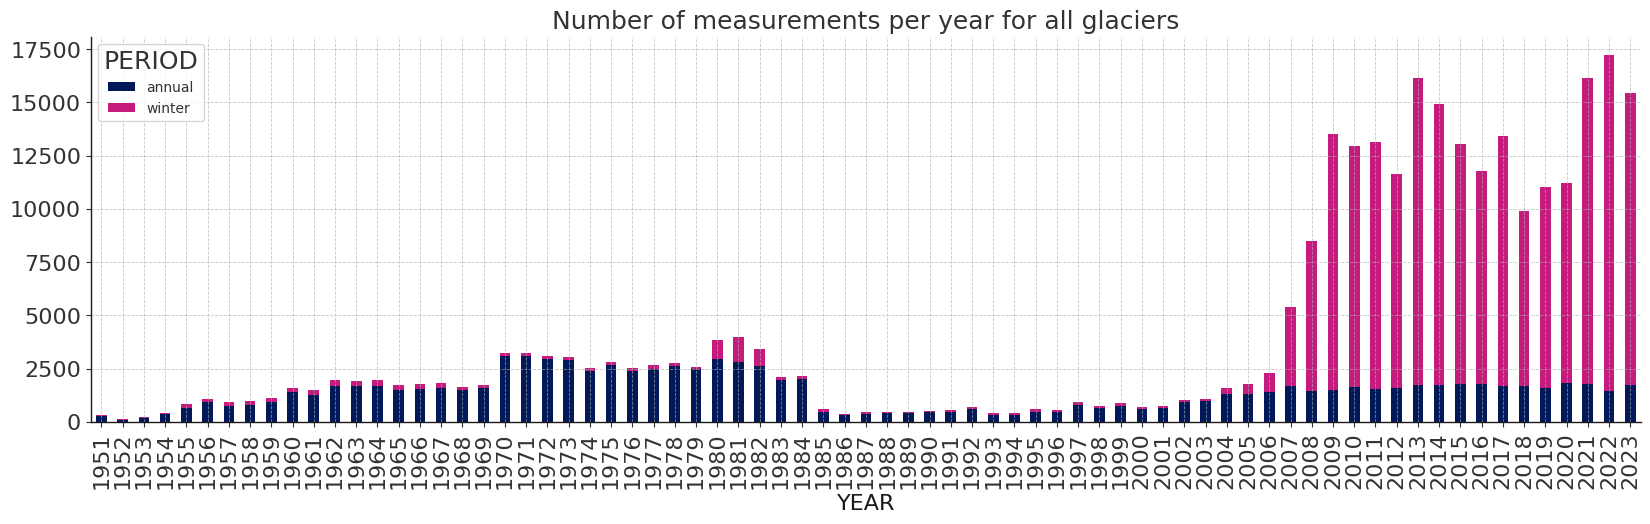

In [15]:
# Number of measurements per year:
dataloader_gl.data.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, figsize=(20, 5), color=[color_xgb, color_tim])
plt.title('Number of measurements per year for all glaciers')

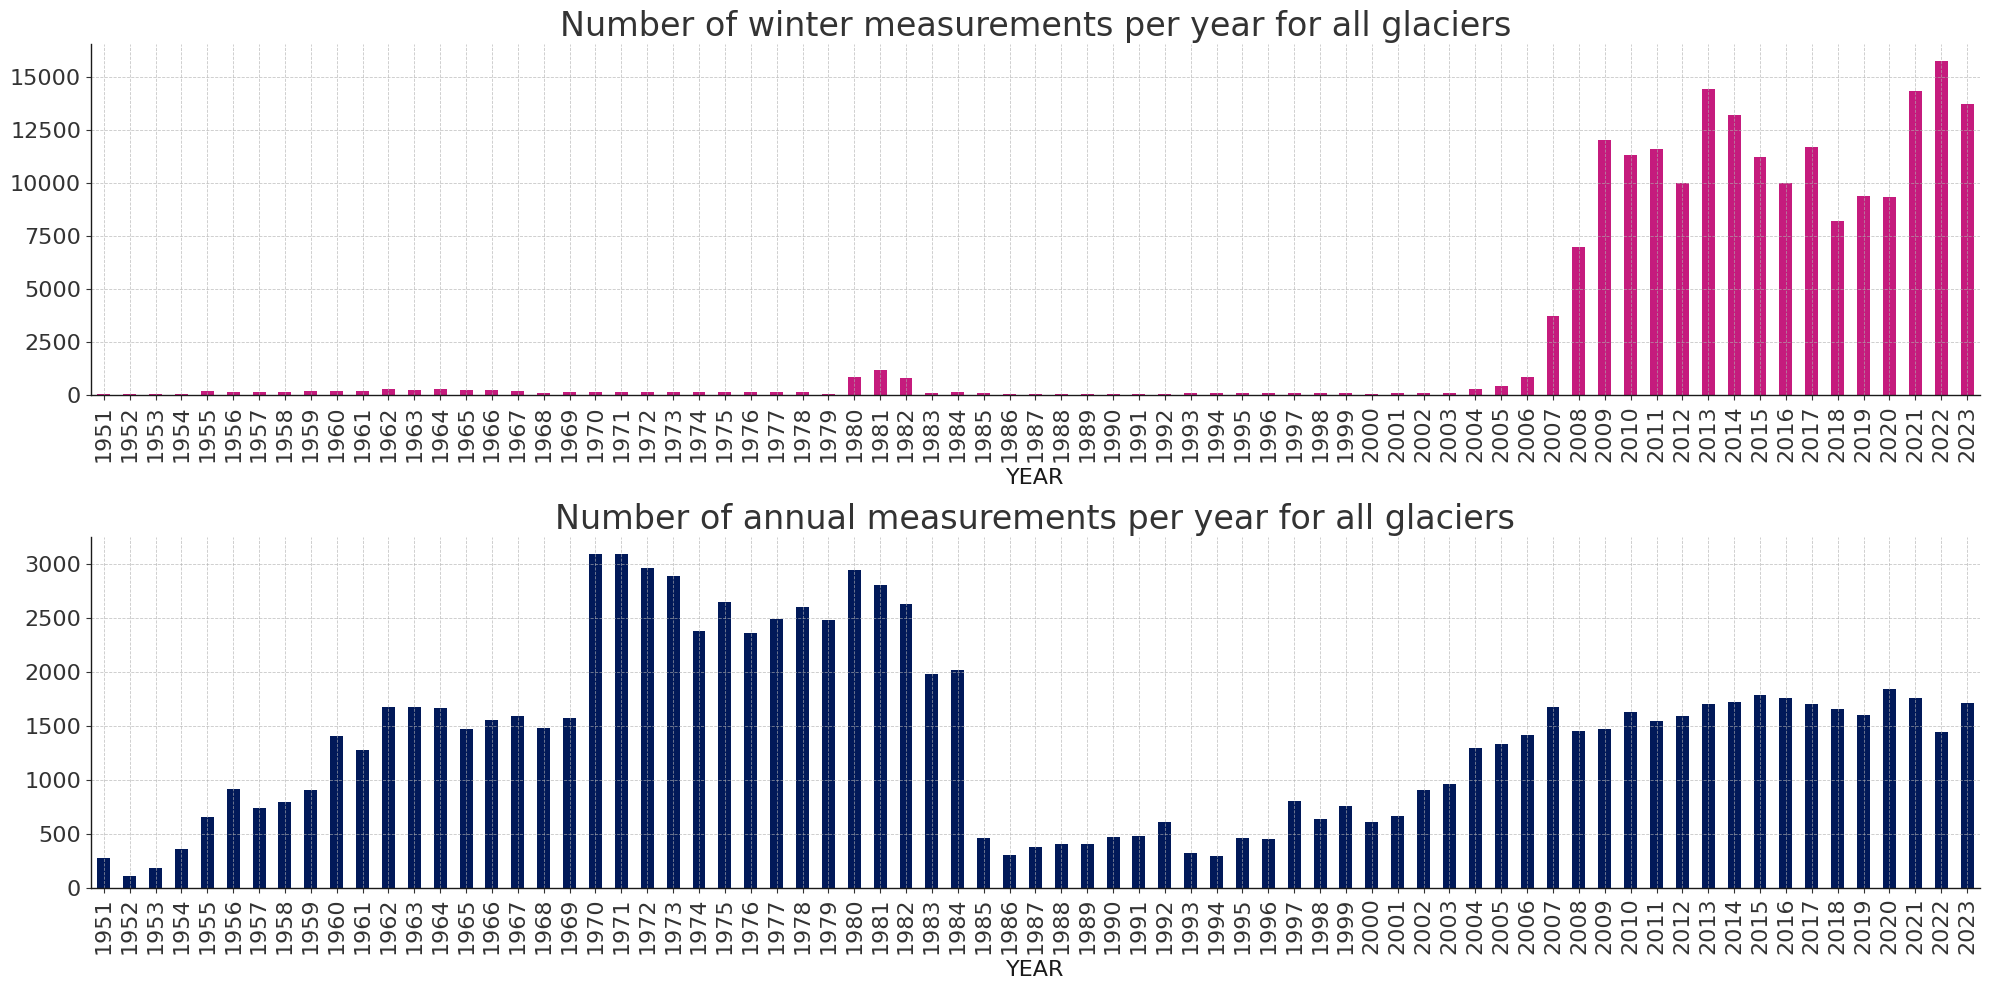

In [16]:
# Plot winter and annual separately:
fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharey=False)
dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(kind='bar',
                                              ax=axs[0],
                                              color=[color_tim],
                                              legend=False)
axs[0].set_title('Number of winter measurements per year for all glaciers',
                 fontsize=24)

dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(kind='bar',
                                              stacked=True,
                                              ax=axs[1],
                                              color=[color_xgb],
                                              legend=False)
axs[1].set_title('Number of annual measurements per year for all glaciers',
                 fontsize=24)
plt.tight_layout()

### Sanity checks:

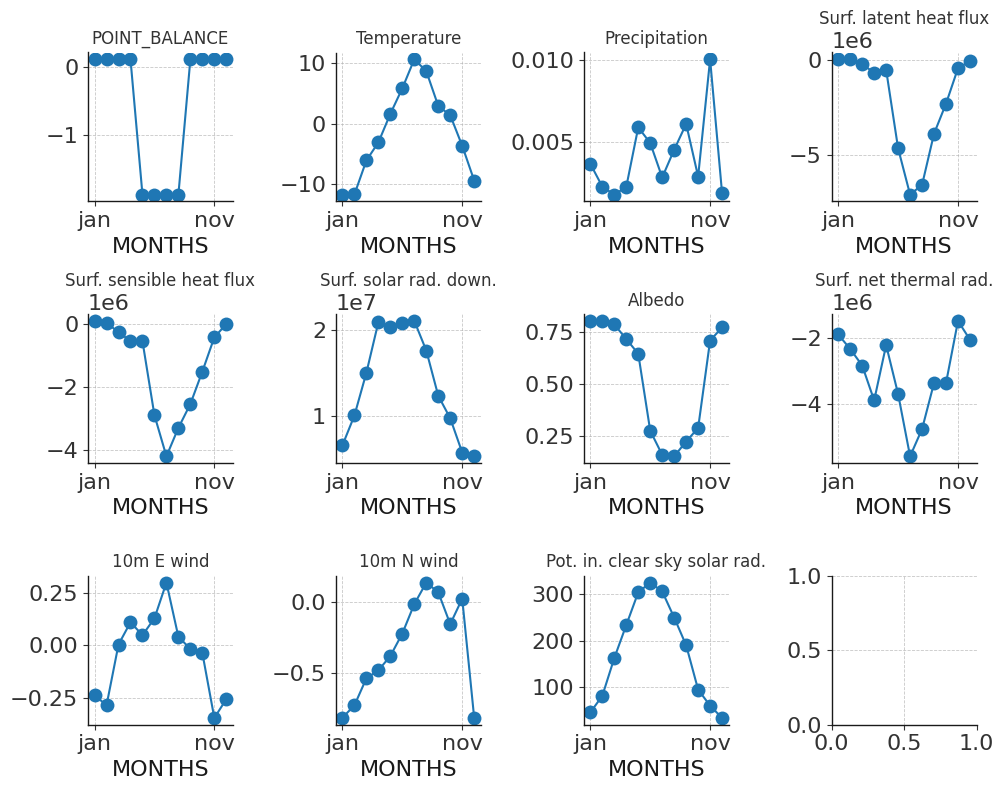

In [17]:
# Sanity check of variables:
df = dataloader_gl.data
var_to_plot = ['POINT_BALANCE'] + vois_climate + ['pcsr']
df = df[(df.GLACIER == 'corvatsch') & (df.YEAR == 2015)].groupby(
    ['MONTHS'])[var_to_plot].mean().reset_index()
df['month_nb'] = df.MONTHS.apply(
    lambda x: list(month_abbr).index(x.capitalize()))
df.sort_values(by='month_nb', inplace=True)
fig, ax = plt.subplots(3, 4, figsize=(10, 8))

for i, var in enumerate(var_to_plot):
    df.plot(x='MONTHS', y=var, marker='o', ax=ax.flatten()[i], legend=False)
    if var in vois_climate_long_name.keys():
        ax.flatten()[i].set_title(vois_climate_long_name[var], fontsize=12)
    else:
        ax.flatten()[i].set_title(var, fontsize=12)
plt.tight_layout()

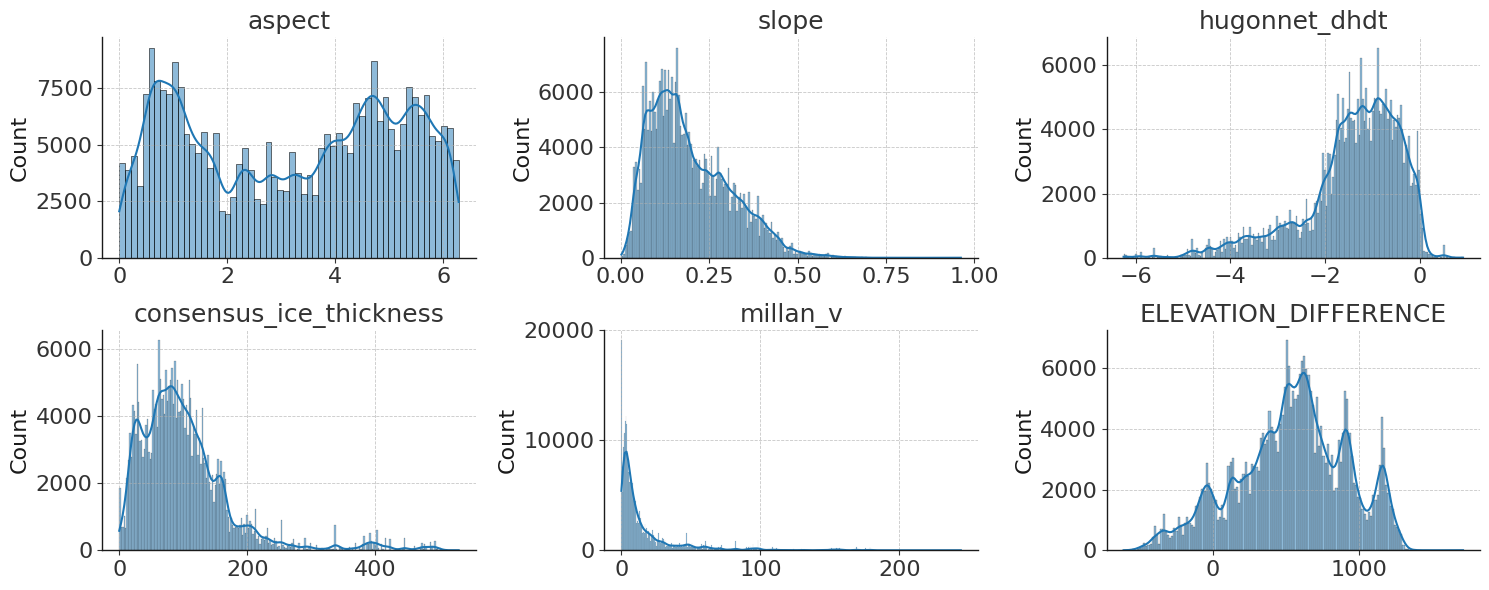

In [18]:
# Plot the distribution of the topo variables:
df = dataloader_gl.data
fig, axs = plt.subplots(2, 3, figsize=(15, 6))
for i, var in enumerate(vois_topographical + ['ELEVATION_DIFFERENCE']):
    ax = axs.flatten()[i]
    sns.histplot(df[var], ax=ax, kde=True)
    ax.set_xlabel('')
    ax.set_title(var)
plt.tight_layout()

## Blocking on glaciers:

In [19]:
test_glaciers = [
    'tortin', 'plattalva', 'sanktanna', 'schwarzberg', 'hohlaub', 'pizol',
    'joeri', 'corvatsch', 'tsanfleuron'
]
train_glaciers = [
    i for i in dataloader_gl.data.GLACIER.unique() if i not in test_glaciers
]

data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))

test_perc = (len(data_test) / len(data_train)) * 100
print('Percentage of test size: {:.2f}%'.format(test_perc))

Size of test data: 32974
Size of train data: 267931
Percentage of test size: 12.31%


In [20]:
# Number of annual versus winter measurements:
print('Train:')
print('Number of winter and annual samples:', len(data_train))
print('Number of annual samples:',
      len(data_train[data_train.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_train[data_train.PERIOD == 'winter']))

# Same for test
print('Test:')
print('Number of winter and annual samples:', len(data_test))
print('Number of annual samples:',
      len(data_test[data_test.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_test[data_test.PERIOD == 'winter']))

print('Total:')
print('Number of monthly rows:', len(dataloader_gl.data))
print('Number of annual rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual']))
print('Number of winter rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter']))

Train:
Number of winter and annual samples: 267931
Number of annual samples: 93332
Number of winter samples: 174599
Test:
Number of winter and annual samples: 32974
Number of annual samples: 8920
Number of winter samples: 24054
Total:
Number of monthly rows: 300905
Number of annual rows: 102252
Number of winter rows: 198653


#### Heatmap annual:

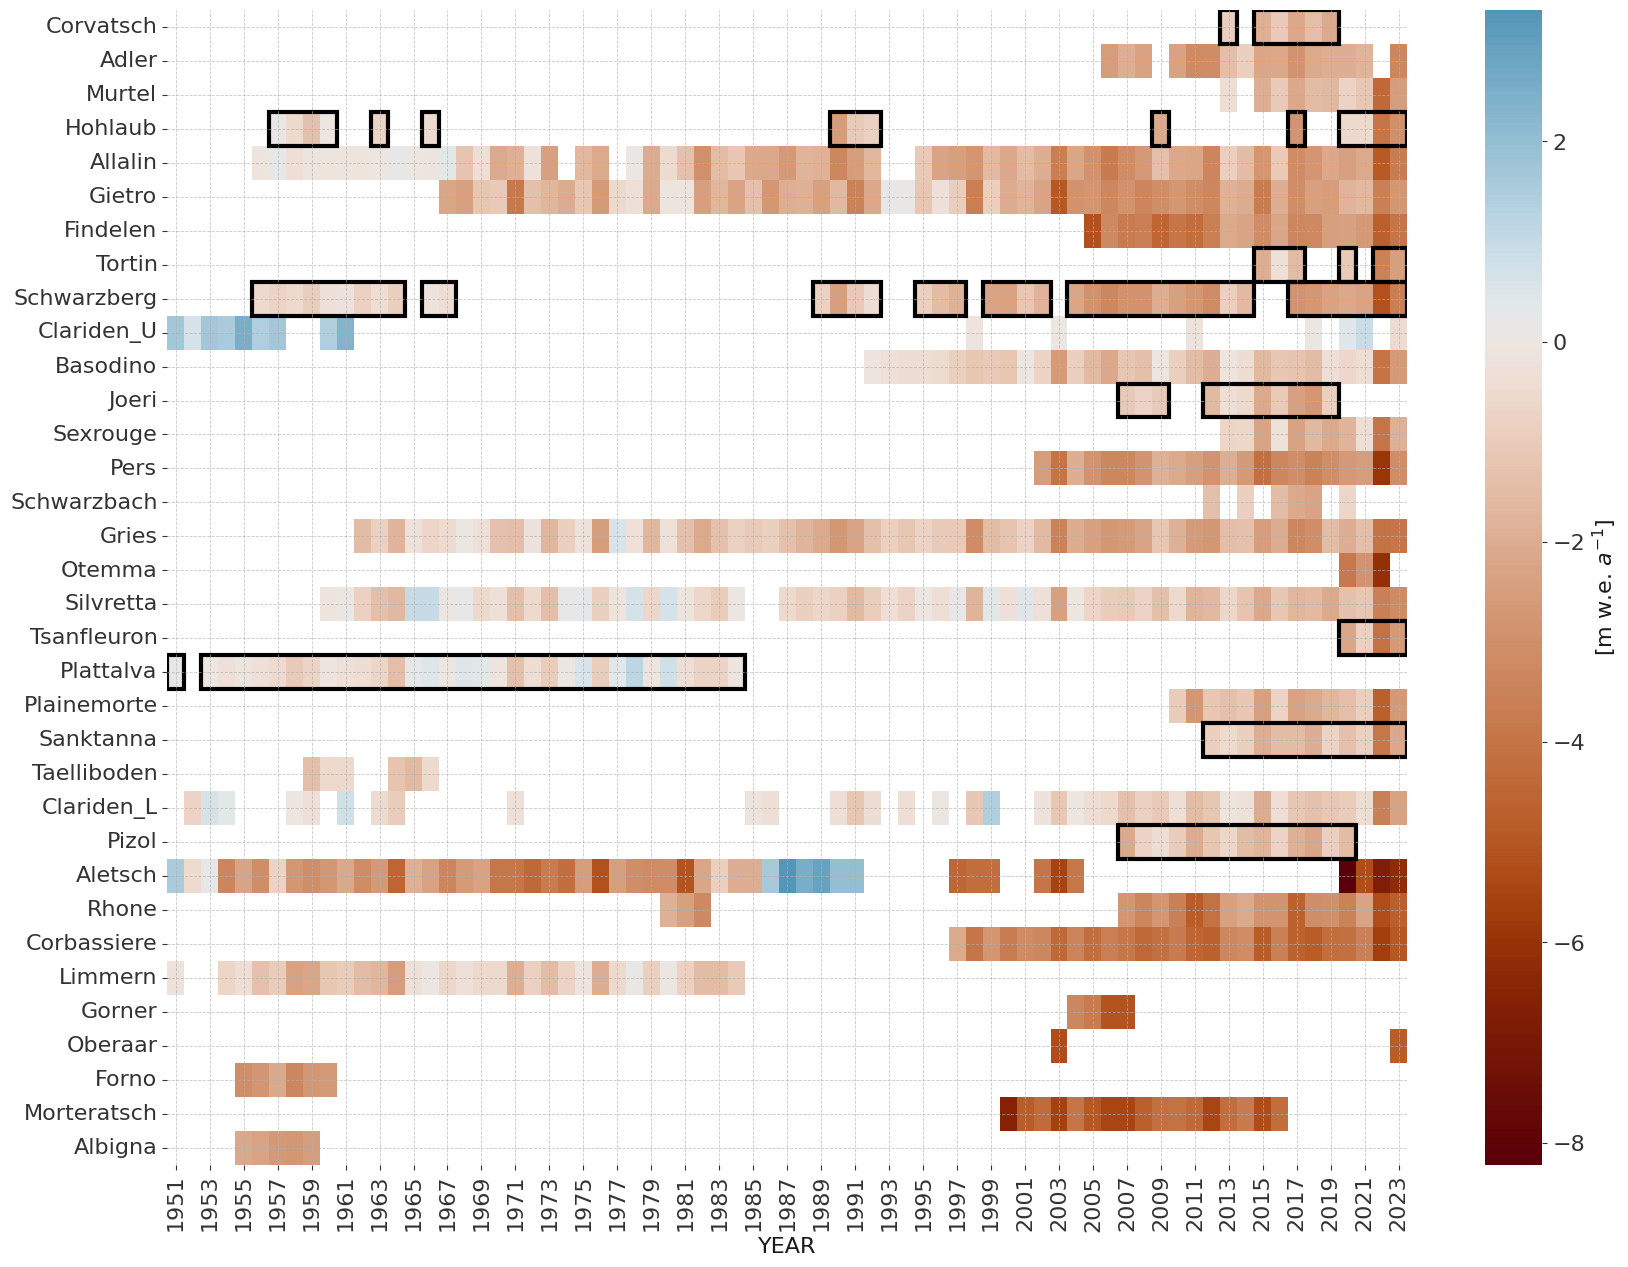

In [21]:
plotHeatmap(test_glaciers, data_glamos, glacierCap, period='annual')

#### Heatmap winter:

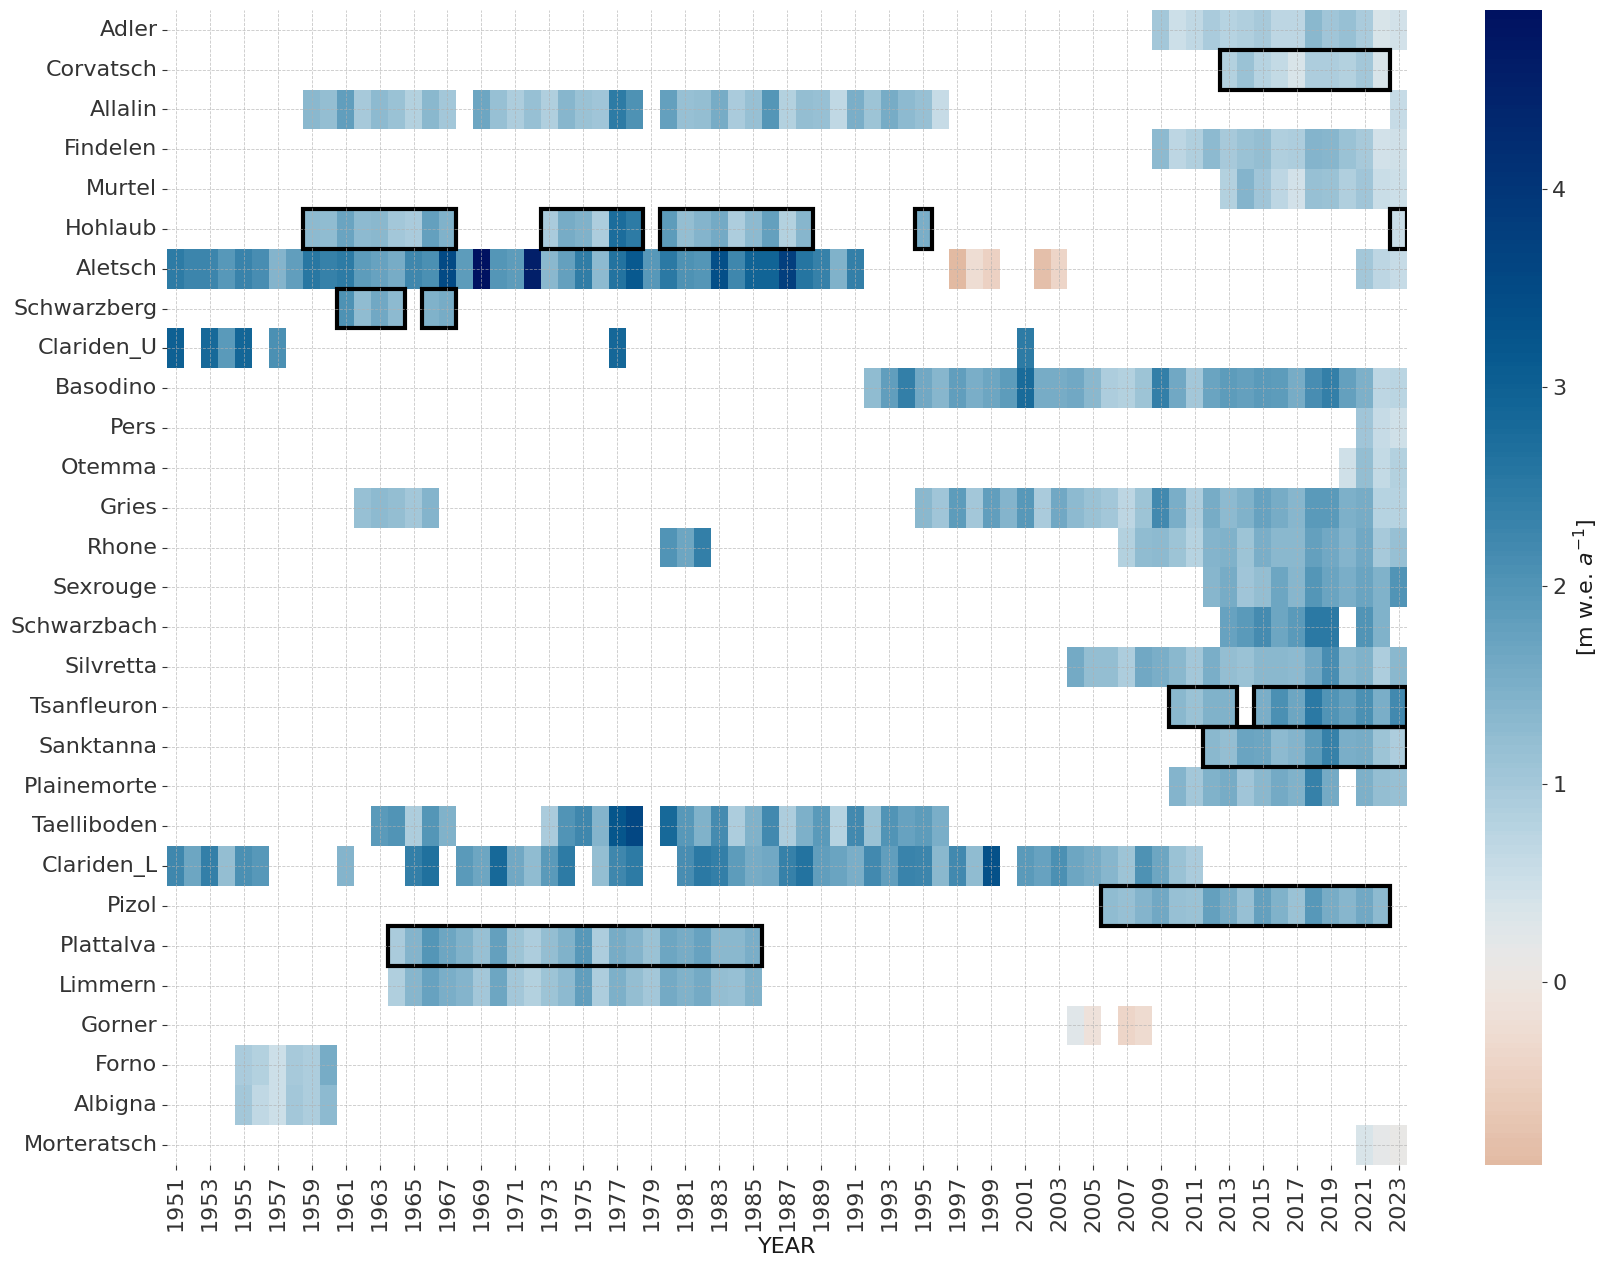

In [22]:
plotHeatmap(test_glaciers, data_glamos, glacierCap, period='winter')

#### CV splits:

Test glaciers: (9) ['corvatsch' 'hohlaub' 'joeri' 'pizol' 'plattalva' 'sanktanna'
 'schwarzberg' 'tortin' 'tsanfleuron']
Percentage of test size: 12.31%
Size of test set: 32974
Train glaciers: (25) ['adler' 'albigna' 'aletsch' 'allalin' 'basodino' 'claridenL' 'claridenU'
 'corbassiere' 'findelen' 'forno' 'gietro' 'gorner' 'gries' 'limmern'
 'morteratsch' 'murtel' 'oberaar' 'otemma' 'pers' 'plainemorte' 'rhone'
 'schwarzbach' 'sexrouge' 'silvretta' 'taelliboden']
Size of train set: 267931


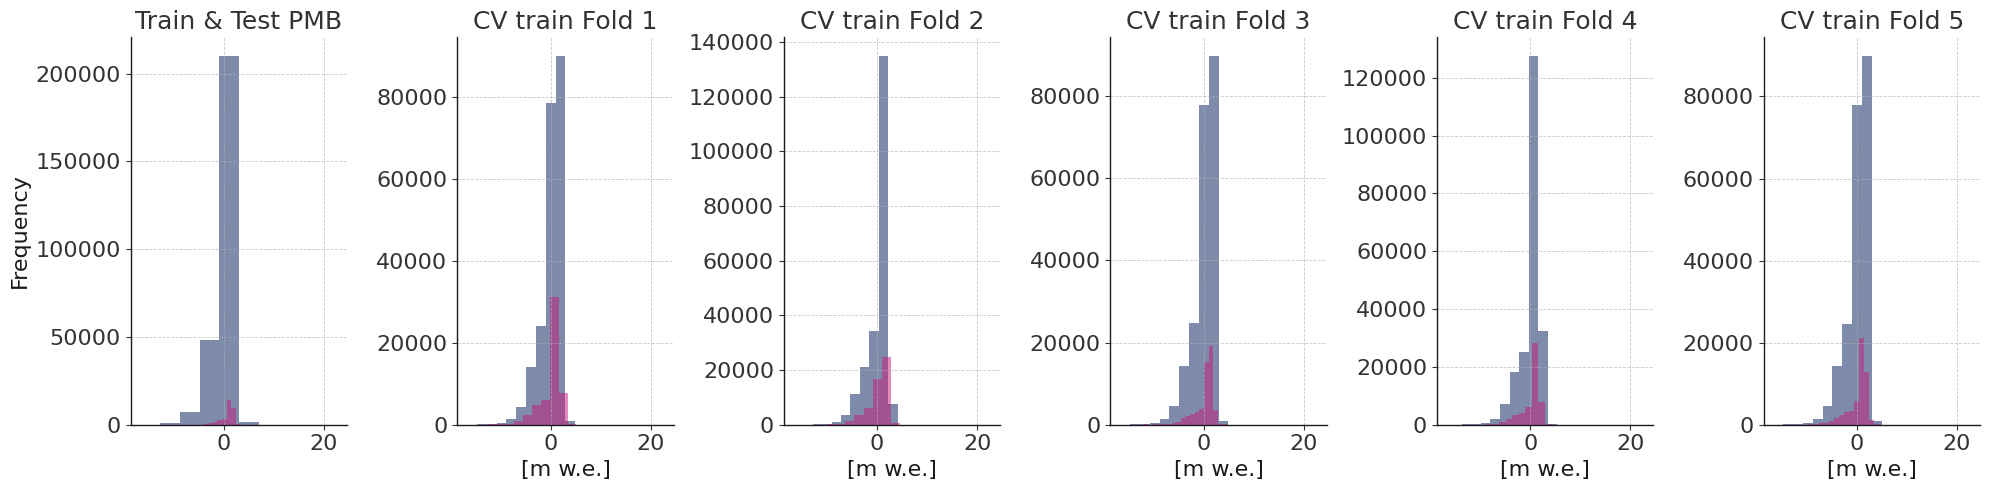

In [23]:
splits, test_set, train_set = getCVSplits(dataloader_gl,
                                          test_split_on='GLACIER',
                                          test_splits=test_glaciers)

print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))
test_perc = (len(test_set['df_X']) / len(train_set['df_X'])) * 100
print('Percentage of test size: {:.2f}%'.format(test_perc))
print('Size of test set:', len(test_set['df_X']))
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                       train_set['splits_vals']))
print('Size of train set:', len(train_set['df_X']))
visualiseSplits(test_set['y'], train_set['y'], splits)


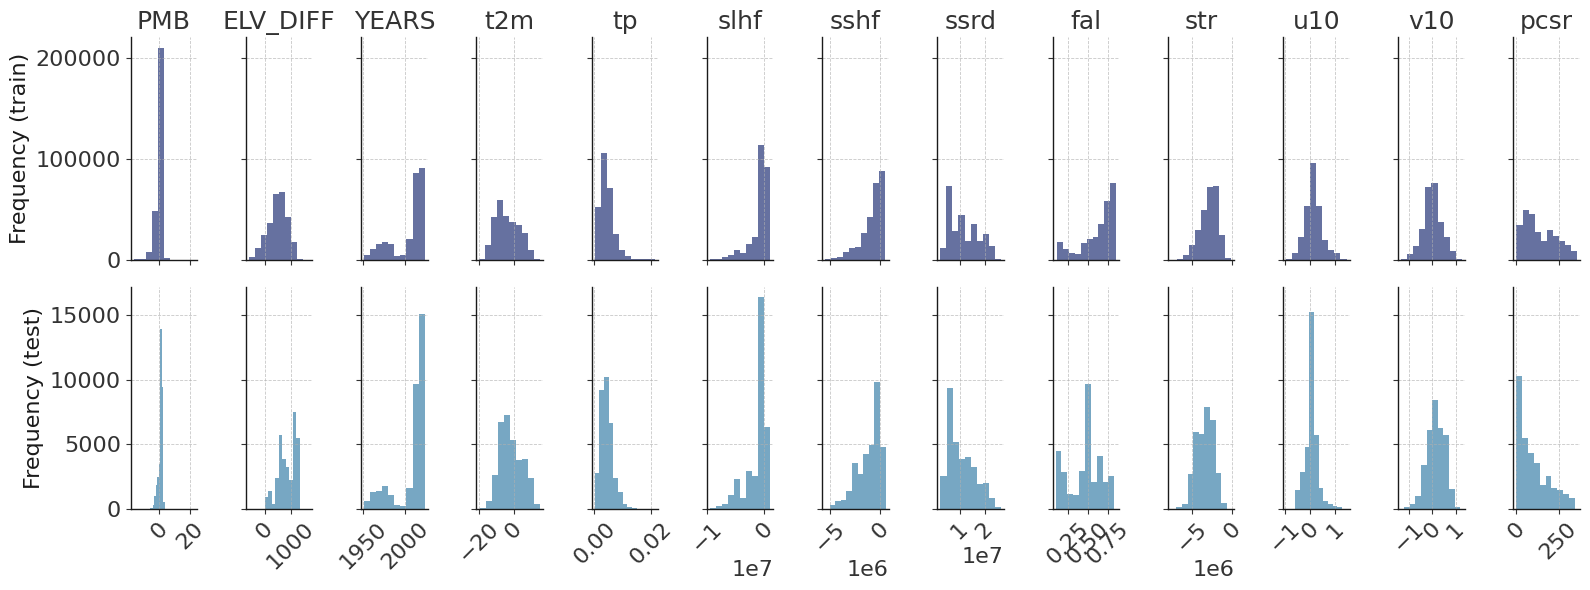

In [24]:
visualiseInputs(train_set, test_set, vois_climate)

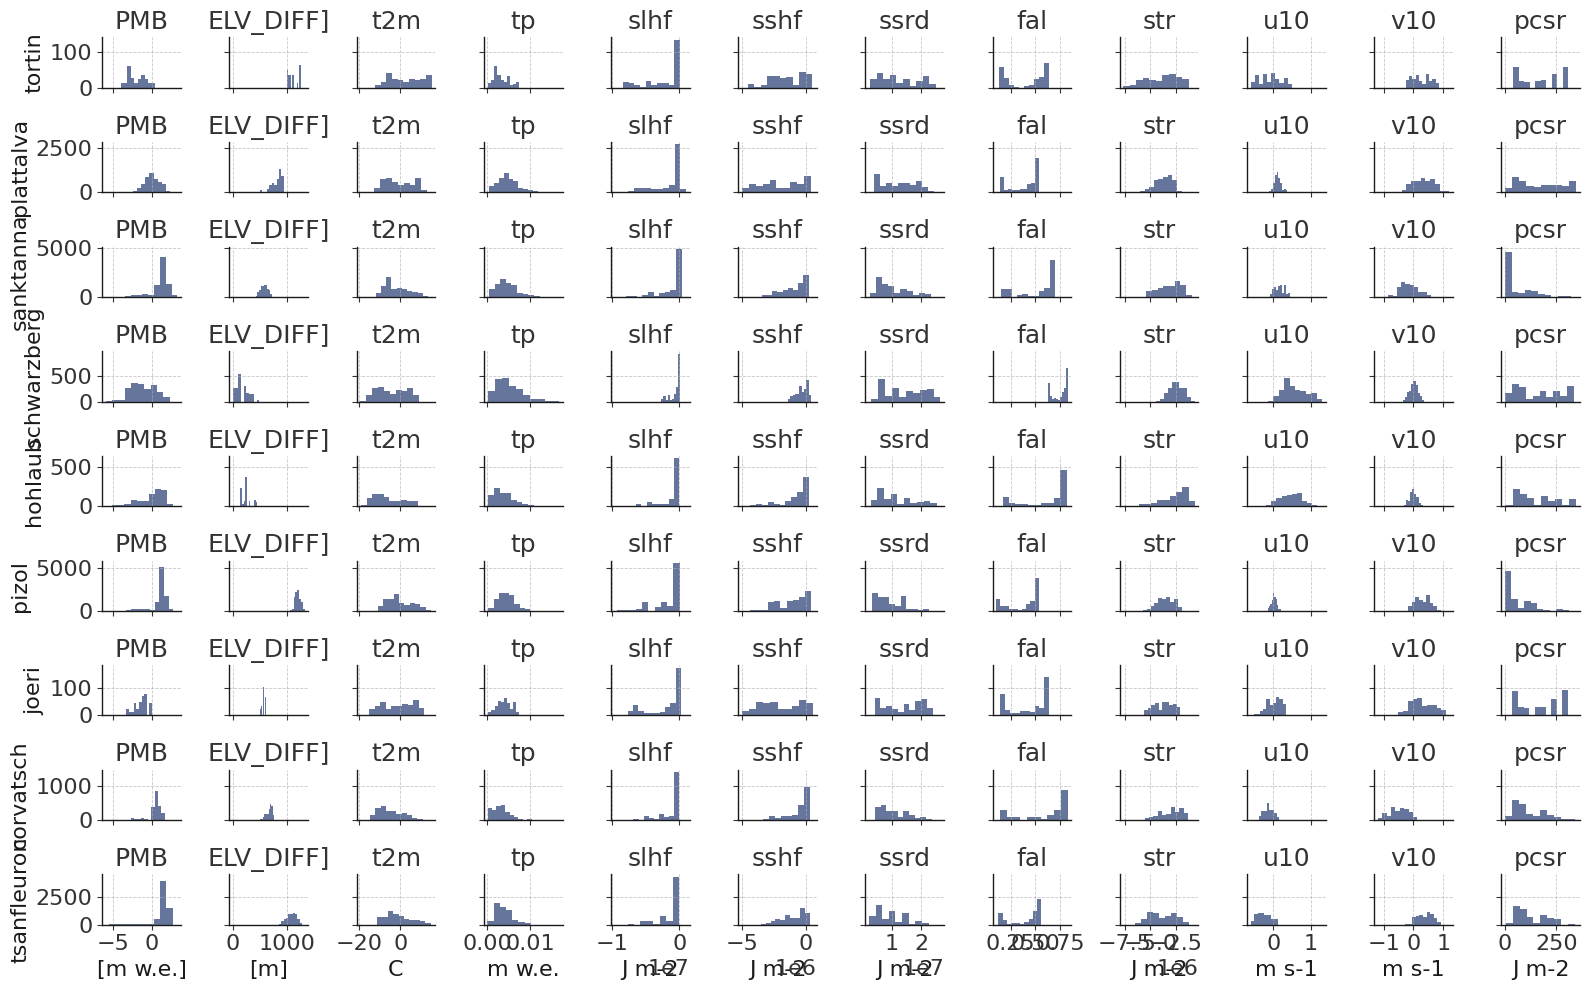

In [25]:
# plot distributions of test glaciers:
f, ax = plt.subplots(len(test_glaciers),
                     len(vois_climate) + 3,
                     figsize=(16, 10),
                     sharey='row',
                     sharex='col')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl['POINT_BALANCE'].plot.hist(ax=ax[i, 0],
                                          color=color_xgb,
                                          alpha=0.6,
                                          density=False)
    ax[i, 0].set_title('PMB')
    ax[i, 0].set_ylabel(test_gl)
    ax[i, 0].set_xlabel('[m w.e.]')
    test_df_gl['ELEVATION_DIFFERENCE'].plot.hist(ax=ax[i, 1],
                                                 color=color_xgb,
                                                 alpha=0.6,
                                                 density=False)
    ax[i, 1].set_title('ELV_DIFF]')
    ax[i, 1].set_xlabel('[m]')

    for j, voi_clim in enumerate(vois_climate + ['pcsr']):
        ax[i, 2 + j].set_title(voi_clim)
        test_df_gl[voi_clim].plot.hist(ax=ax[i, 2 + j],
                                       color=color_xgb,
                                       alpha=0.6,
                                       density=False)
        ax[i, 2 + j].set_xlabel(vois_units[voi_clim])

plt.tight_layout()

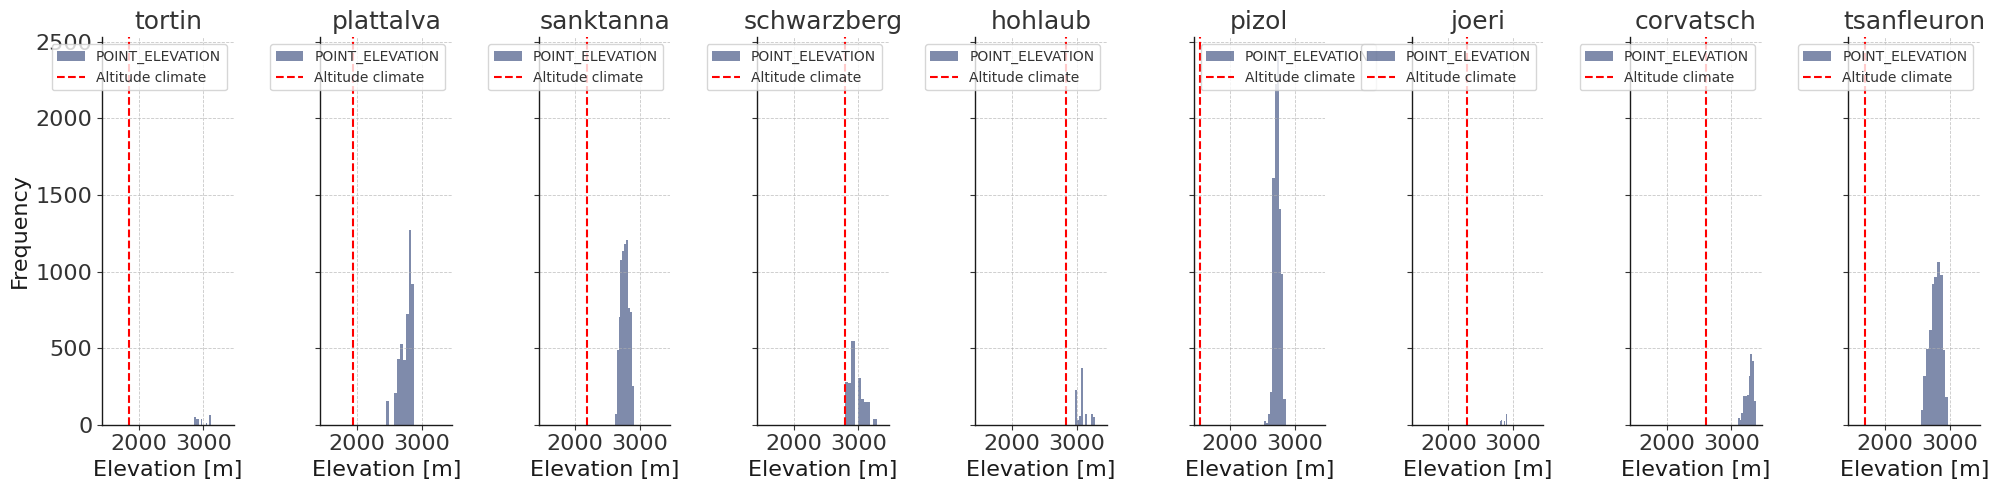

In [26]:
f, ax = plt.subplots(1,
                     len(test_glaciers),
                     figsize=(20, 5),
                     sharey='row',
                     sharex='row')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl.POINT_ELEVATION.plot.hist(color=color_xgb,
                                         alpha=0.5,
                                         density=False,
                                         ax=ax[i])
    # add vertical line for altitude climate
    alt_climate = test_df_gl.ALTITUDE_CLIMATE.mean()
    ax[i].axvline(x=alt_climate,
                  color='red',
                  linestyle='--',
                  label='Altitude climate')
    ax[i].set_xlabel('Elevation [m]')
    ax[i].legend()
    ax[i].set_title(test_gl)
plt.tight_layout()

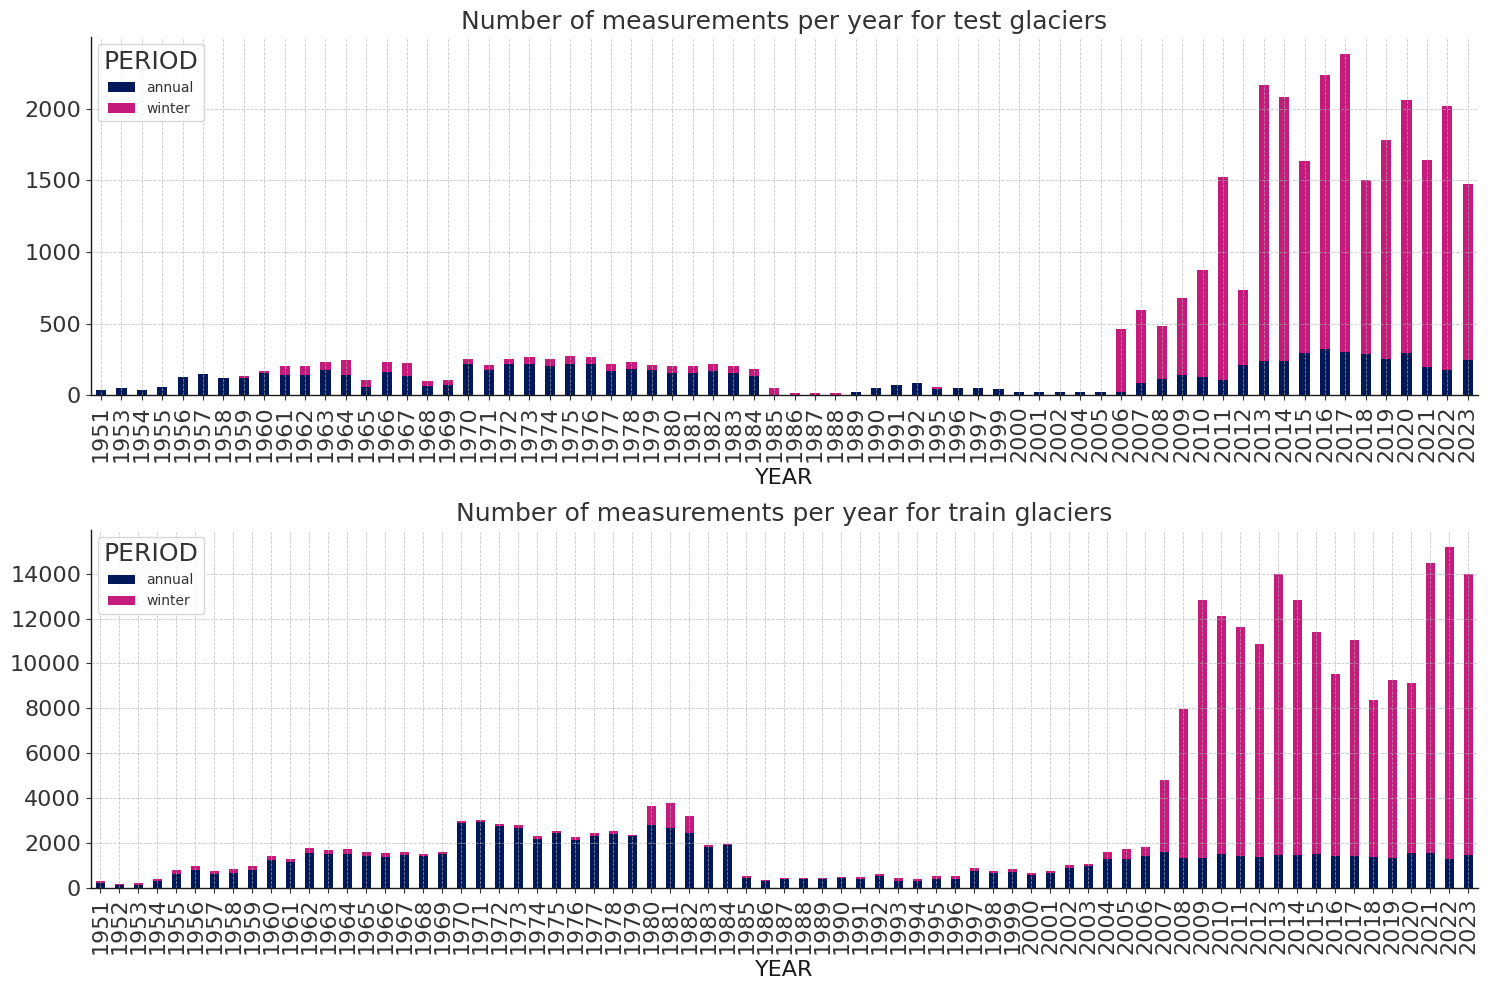

In [27]:
# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
data_test.groupby(['YEAR', 'PERIOD'
                   ]).size().unstack().plot(kind='bar',
                                            stacked=True,
                                            color=[color_xgb, color_tim],
                                            ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
data_train.groupby(['YEAR', 'PERIOD'
                    ]).size().unstack().plot(kind='bar',
                                             stacked=True,
                                             color=[color_xgb, color_tim],
                                             ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

## XGBoost:

### Grid search:

In [28]:
# Grid search
# For each of the XGBoost parameter, define the grid range
# param_grid = {
#     'max_depth': [
#         3,
#         4,
#         5,
#         6,
#     ],
#     'learning_rate': [0.01, 0.1, 0.2, 0.3],
#     'n_estimators': [100, 200, 300],
#     'gamma': [0, 1]
# }
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = config.SEED
param_init["n_jobs"] = config.NUM_JOBS

In [29]:
vois_climate

['t2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10']

In [30]:
# vois_climate = [
#     't2m_corr', 'tp_corr', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
# ]

In [31]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
all_columns = feature_columns + config.META_DATA + config.NOT_METADATA_NOT_FEATURES
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(**param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # custom_xgboost.gridsearch(
    #     parameters=param_grid,
    #     splits=splits,
    #     features=df_X_train_subset,
    #     targets=train_set['y'],
    # )

    # save best model
    custom_xgboost.save_model(f'xgb_gl_split_full_probes.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor()
    custom_xgboost.load_model(f'xgb_gl_split_full_probes.pkl')

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns], config.META_DATA)
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, config.META_DATA,
                                            features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))


Shape of training dataset: (267931, 27)
Shape of testing dataset: (32974, 27)
Running with features: ['ELEVATION_DIFFERENCE', 't2m_corr', 'tp_corr', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 'pcsr']
Best parameters:
 {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.01}
Best score:
 -0.2313672907729479
Shape of the test: (32974, 16)
Overall score: 0.785954934637778
CPU times: user 3.5 s, sys: 202 ms, total: 3.71 s
Wall time: 537 ms


In [32]:
# visualiseValPreds(best_estimator, splits, train_set, feature_columns)

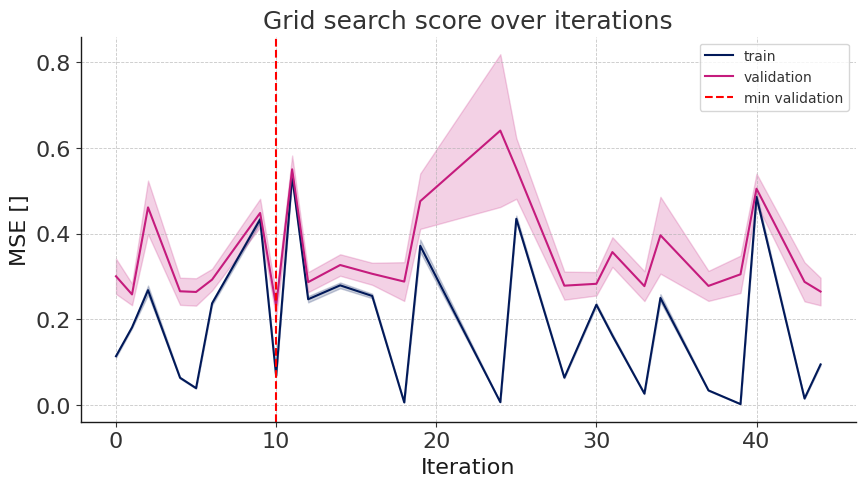

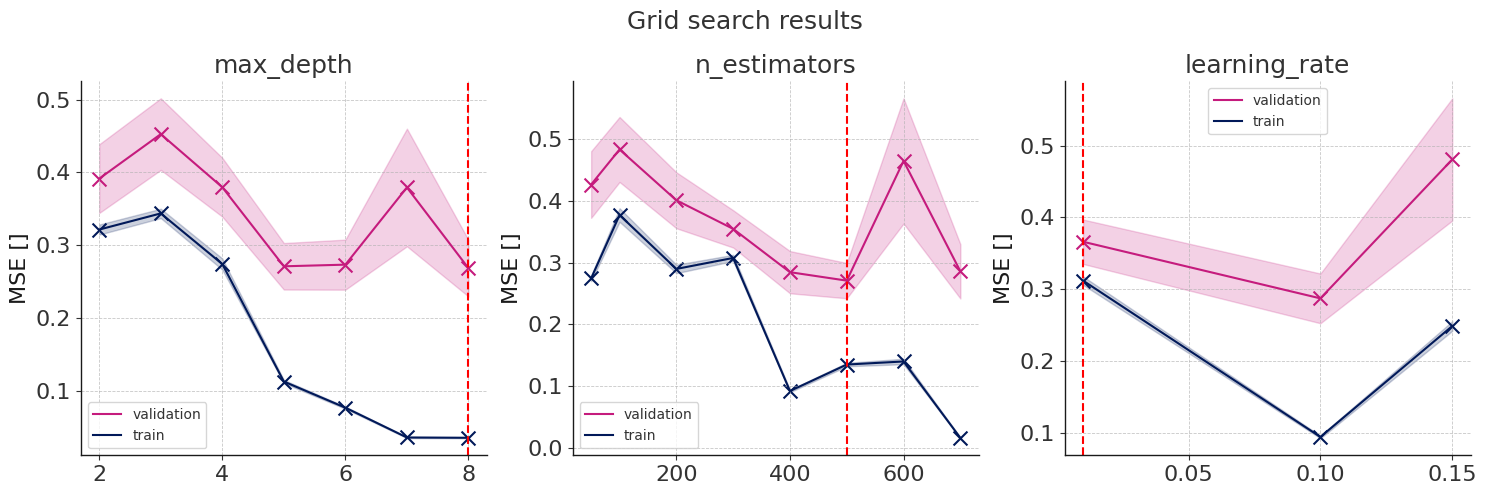

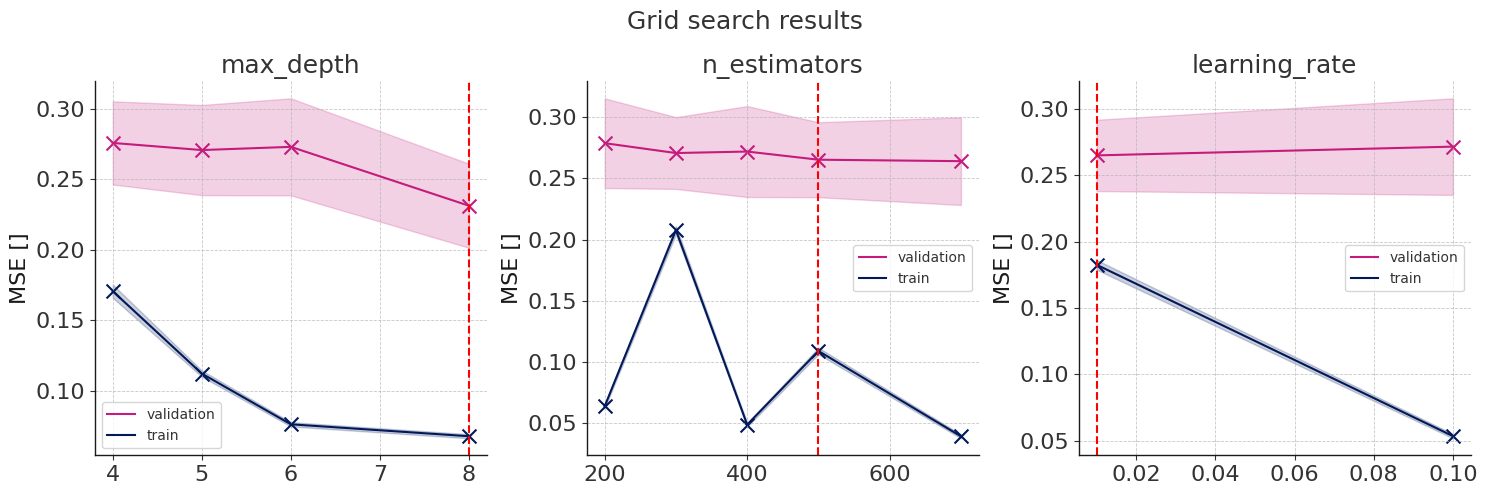

In [33]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_)
plotGridSearchParams(custom_xgboost.param_search.cv_results_, param_grid)
plotGridSearchParams(custom_xgboost.param_search.cv_results_, param_grid, N=10)

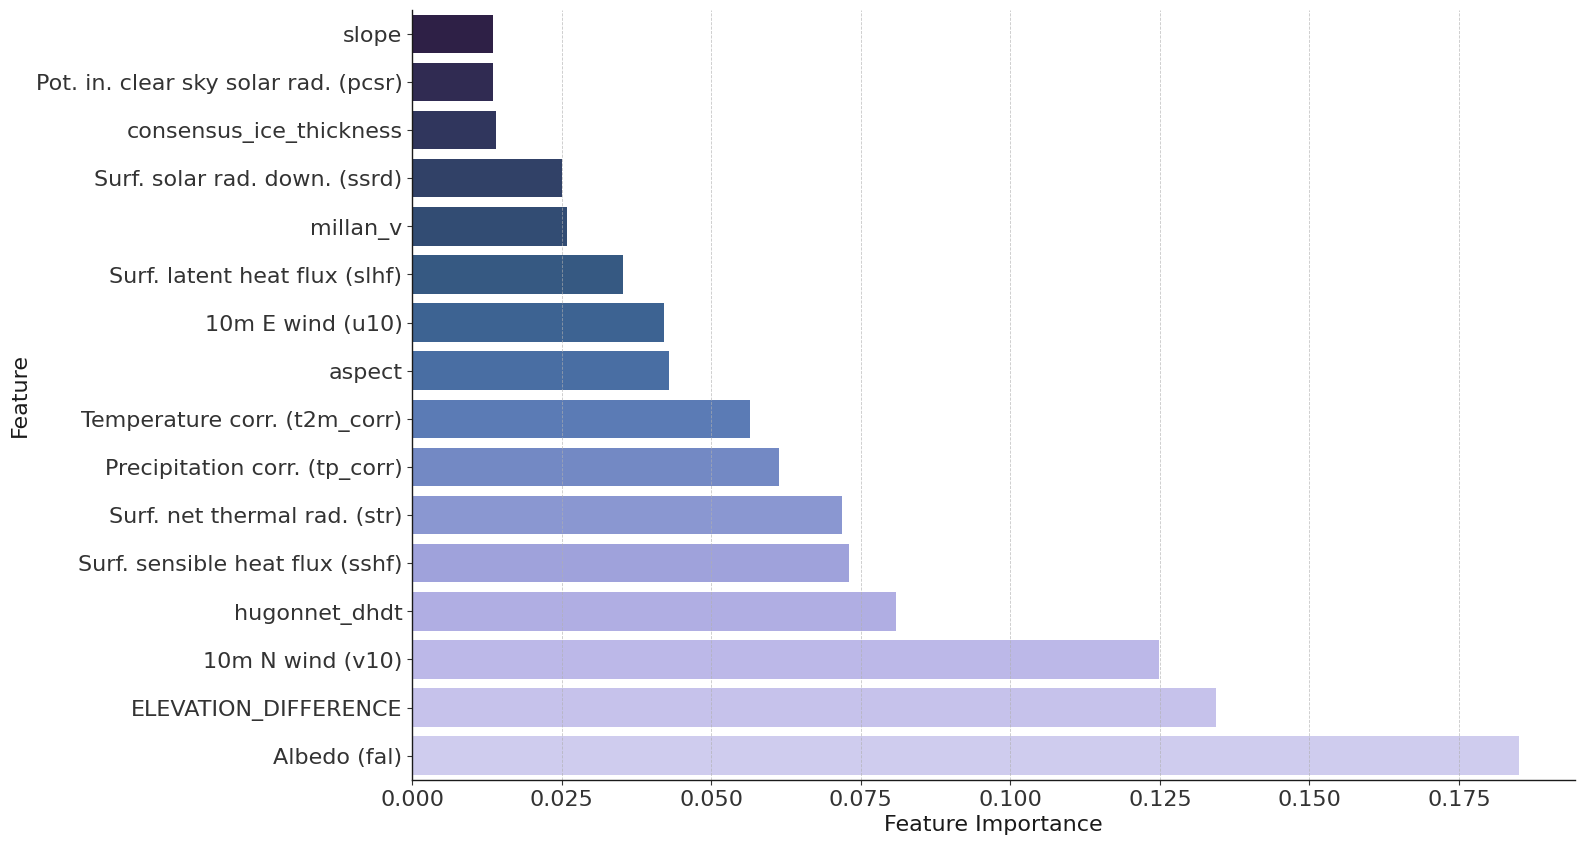

In [34]:
FIPlot(best_estimator, feature_columns, vois_climate)

#### Predictions of best parameters:

Shape of the test: (32974, 16)
{'corvatsch': '#a6cee3', 'hohlaub': '#1f78b4', 'joeri': '#b2df8a', 'pizol': '#33a02c', 'plattalva': '#fb9a99', 'sanktanna': '#e31a1c', 'schwarzberg': '#fdbf6f', 'tortin': '#ff7f00', 'tsanfleuron': '#cab2d6'}


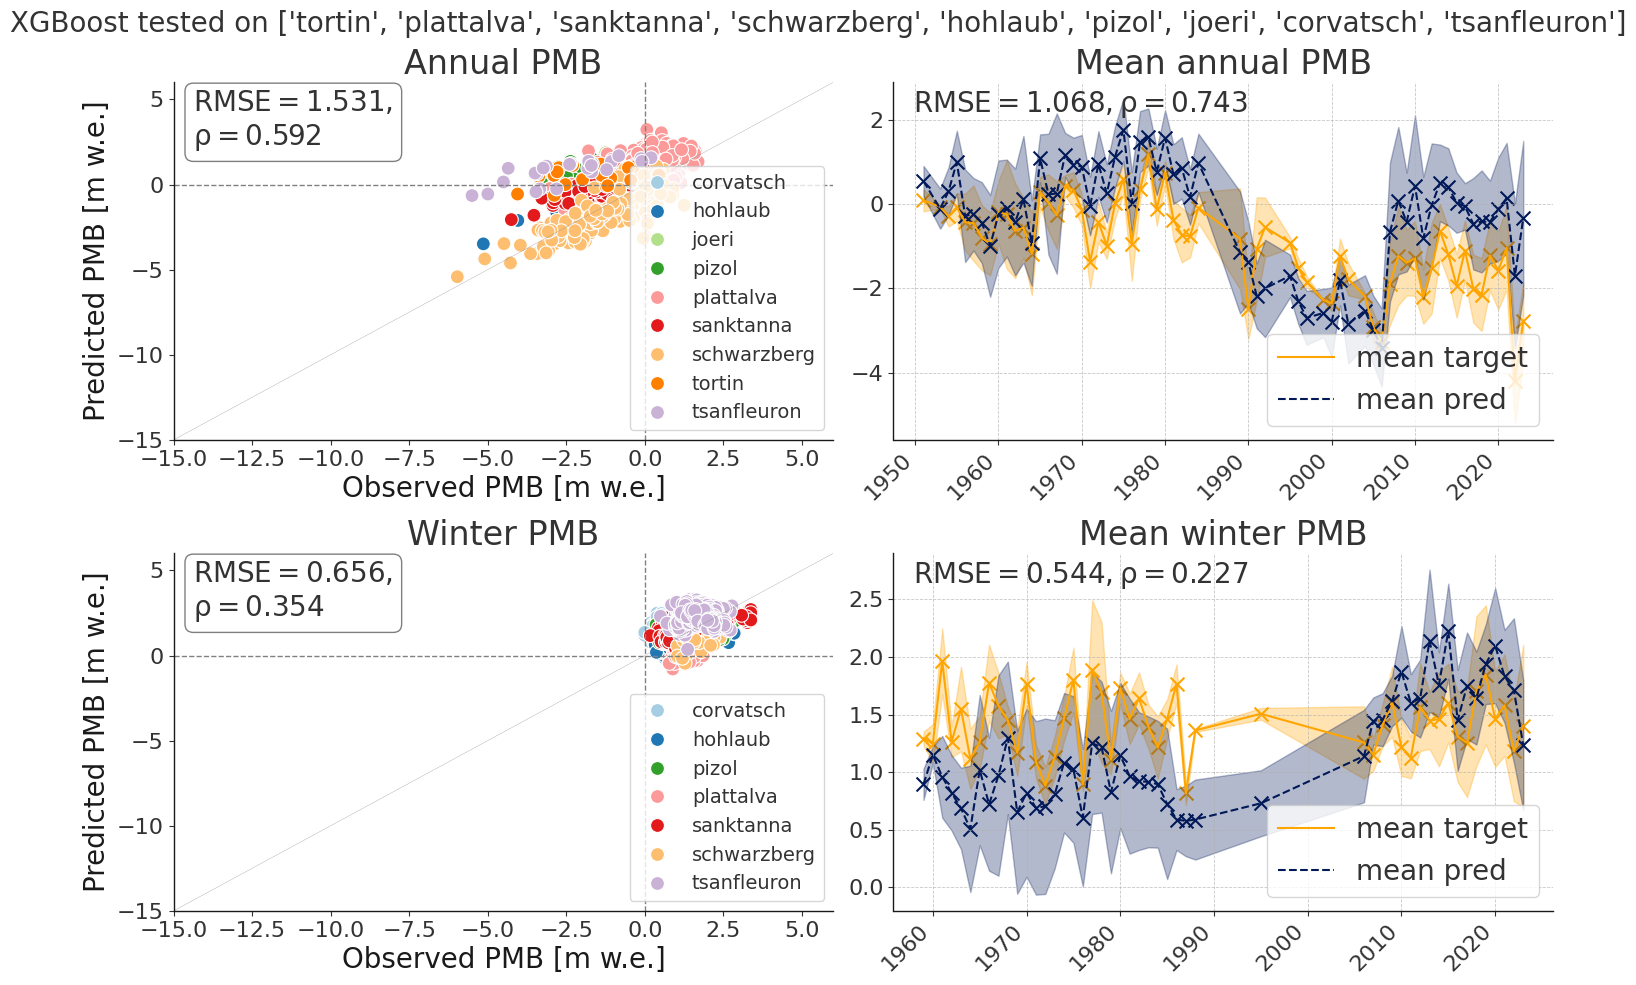

In [35]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns], config.META_DATA)
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, config.META_DATA,
                                            features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost tested on {test_glaciers}', fontsize=20)
plt.tight_layout()


### Predictions of custom parameters:

Shape of training dataset: (267931, 27)
Shape of testing dataset: (32974, 27)
Running with features: ['ELEVATION_DIFFERENCE', 't2m_corr', 'tp_corr', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 'pcsr']
{'device': 'cuda:0', 'tree_method': 'hist', 'random_state': 30, 'n_jobs': 25, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}
Shape of the test: (32974, 16)
Overall score: 0.3376178009202203
{'corvatsch': '#a6cee3', 'hohlaub': '#1f78b4', 'joeri': '#b2df8a', 'pizol': '#33a02c', 'plattalva': '#fb9a99', 'sanktanna': '#e31a1c', 'schwarzberg': '#fdbf6f', 'tortin': '#ff7f00', 'tsanfleuron': '#cab2d6'}


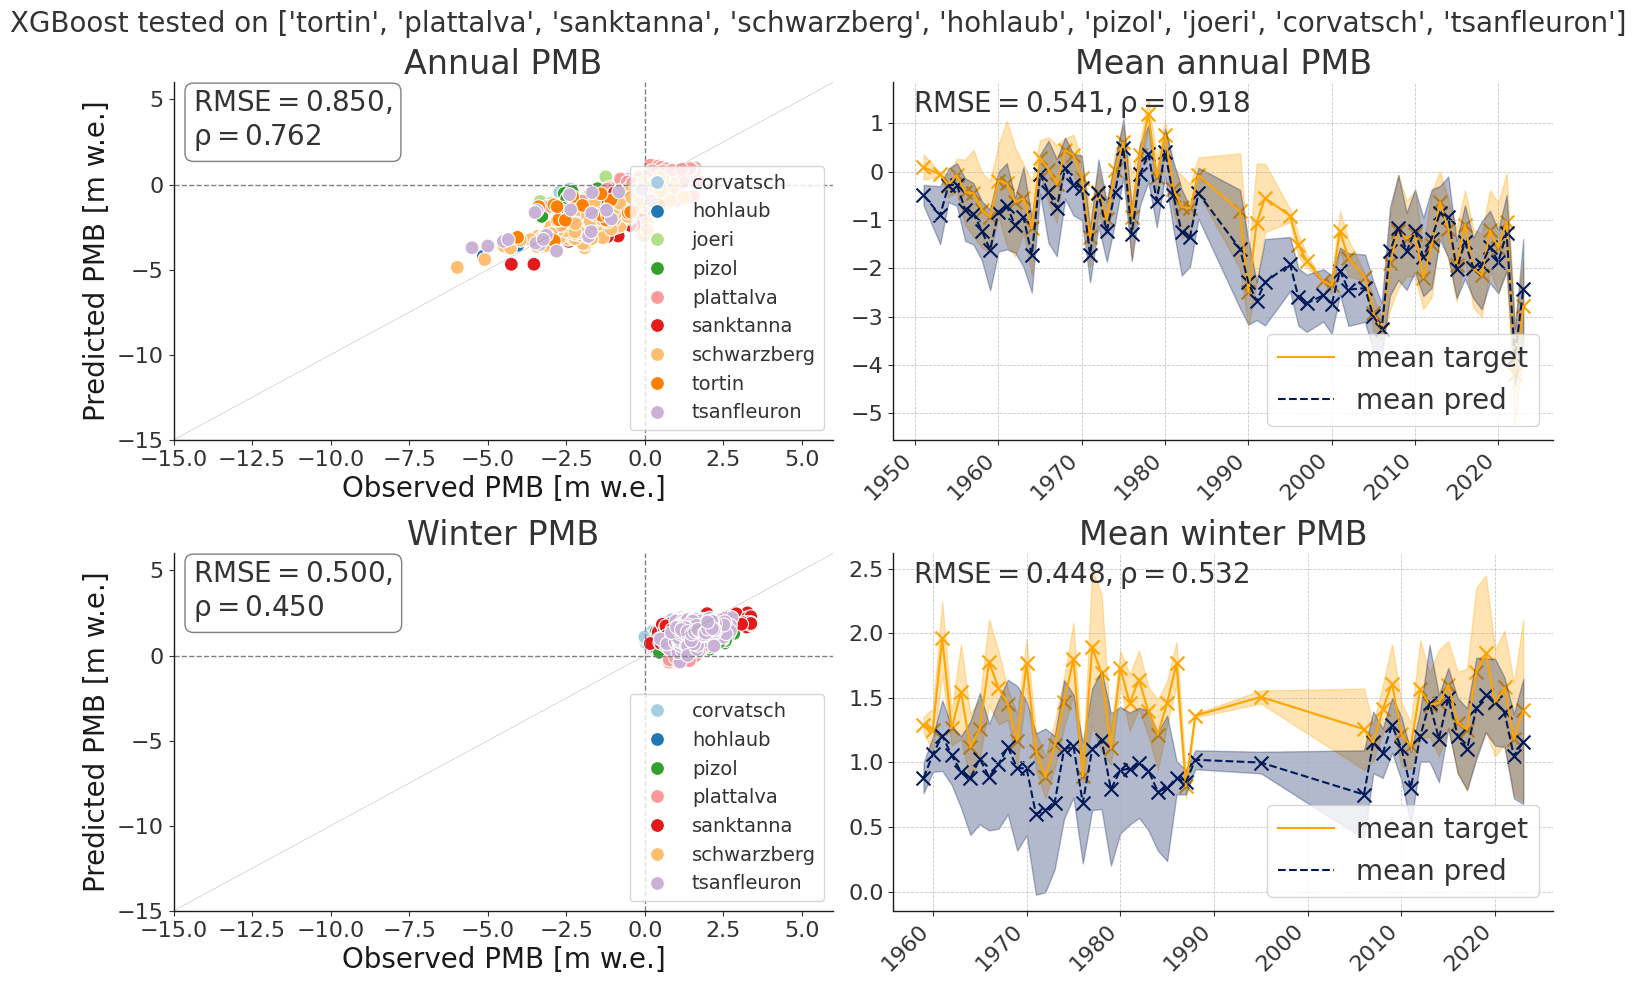

In [36]:
custom_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
all_columns = feature_columns + config.META_DATA + config.NOT_METADATA_NOT_FEATURES
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

params = {**param_init, **custom_params}
print(params)
custom_model = mbm.models.CustomXGBoostRegressor(**params)

# Fit on train data:
custom_model.fit(train_set['df_X'][all_columns], train_set['y'])

# Make predictions on test
custom_model = custom_model.set_params(device='cpu')
features_test, metadata_test = custom_model._create_features_metadata(
    test_set['df_X'][all_columns], config.META_DATA)
y_pred = custom_model.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = custom_model.aggrPredict(metadata_test, config.META_DATA,
                                      features_test)

# Calculate scores
score = custom_model.score(test_set['df_X'][all_columns],
                           test_set['y'])  # negative
print('Overall score:', np.abs(score))

grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set, custom_model)
plt.suptitle(f'XGBoost tested on {test_glaciers}', fontsize=20)
plt.tight_layout()

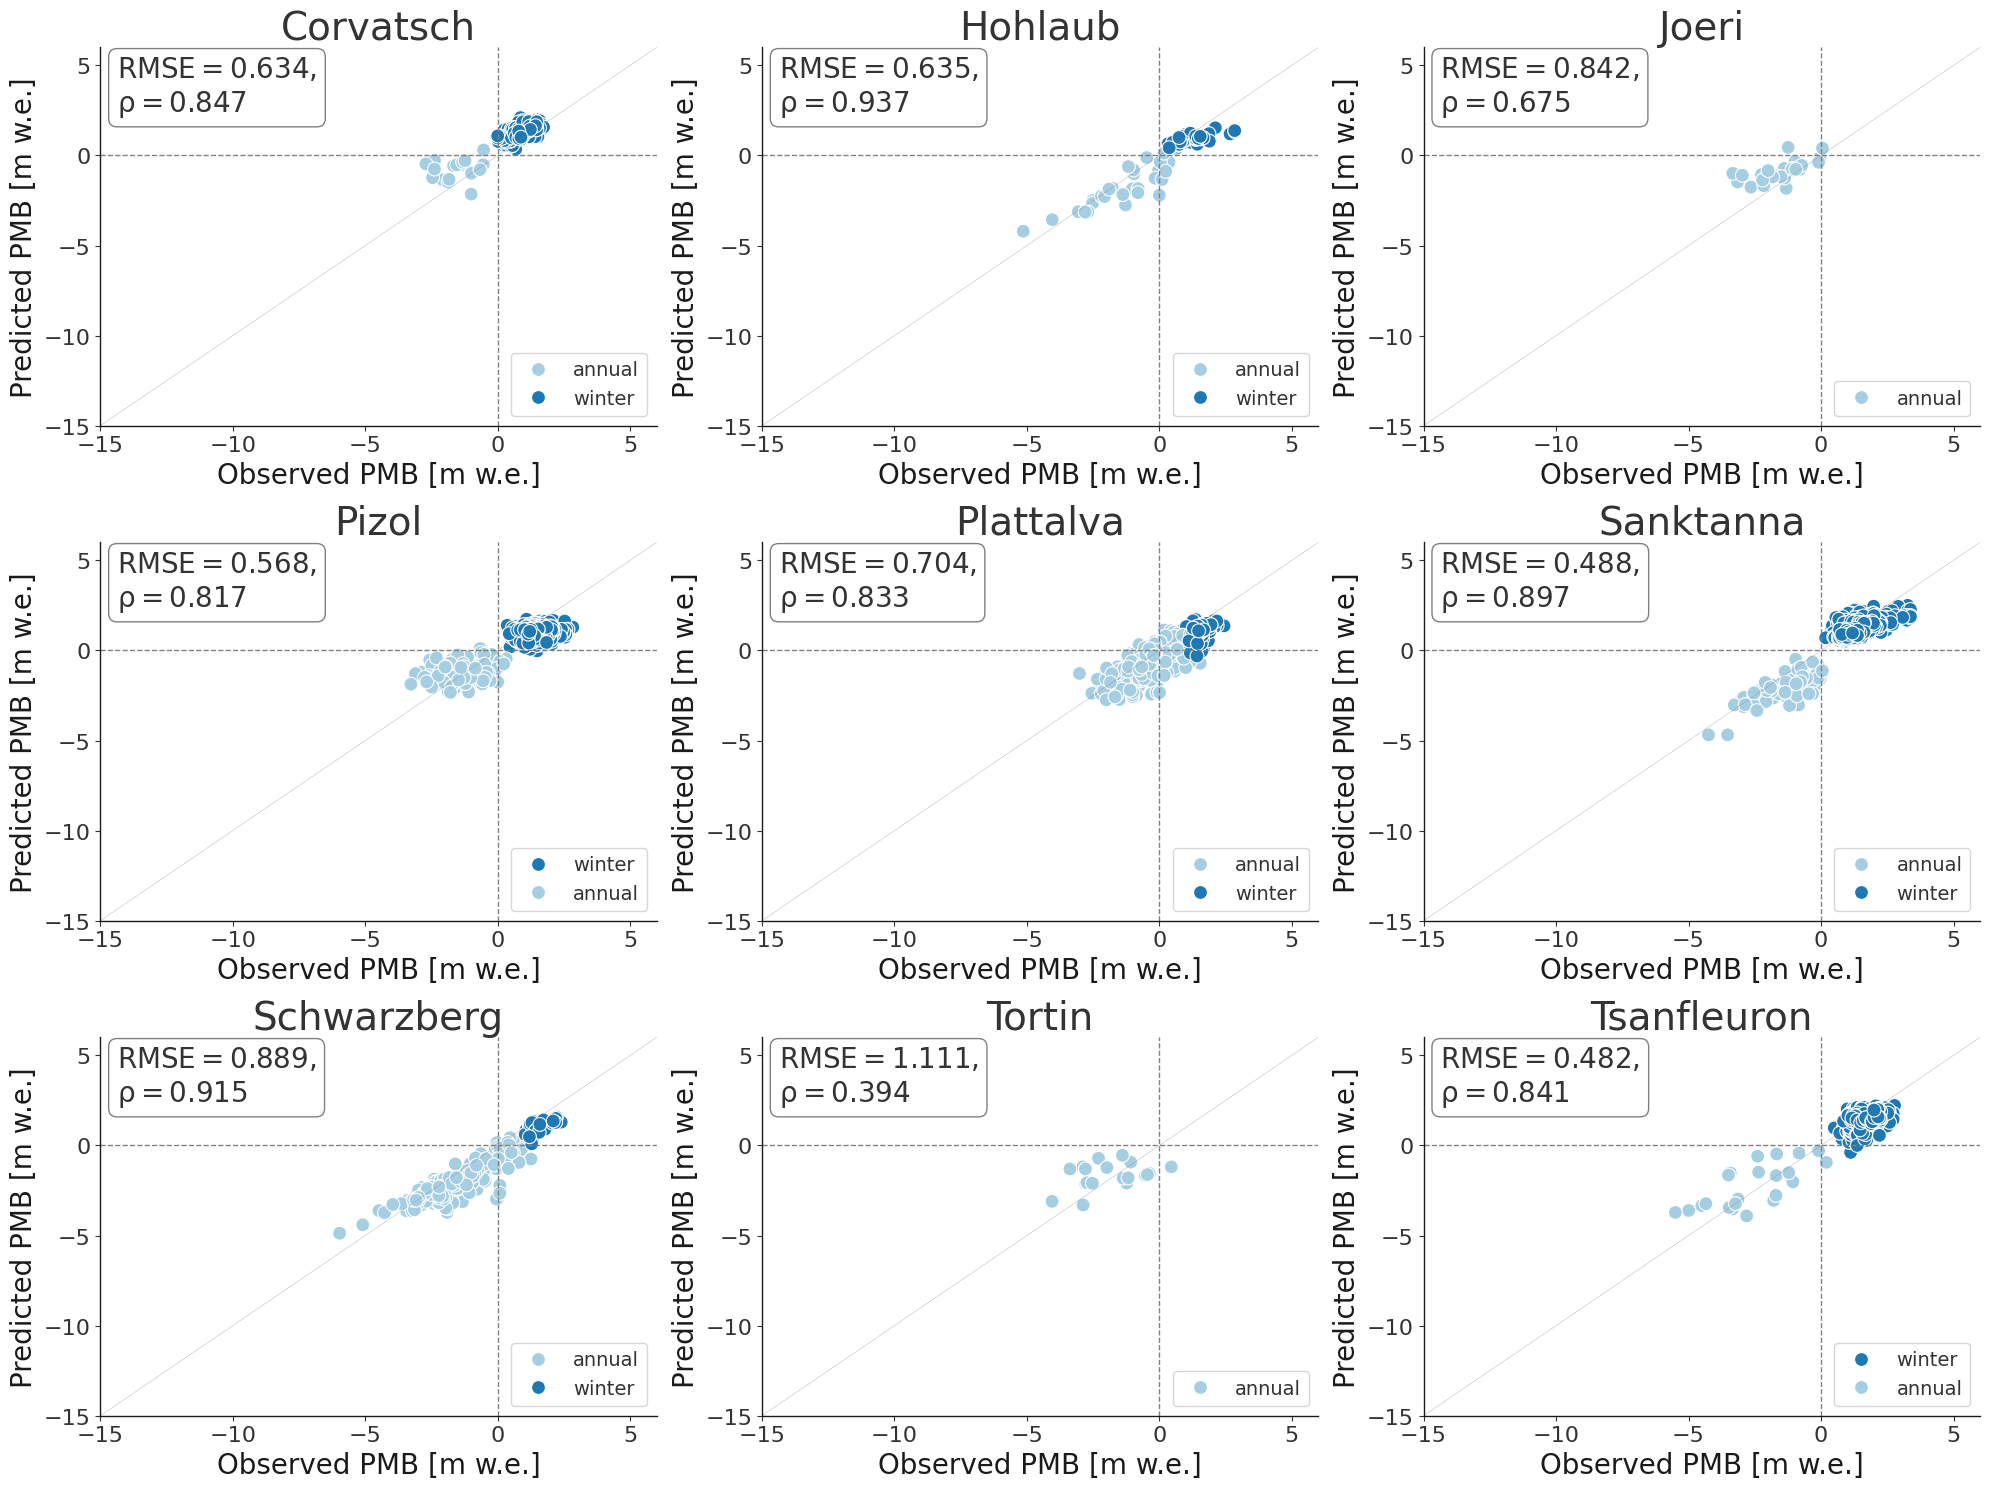

In [37]:
# Aggregate predictions to annual or winter:
PlotIndividualGlacierPredVsTruth(grouped_ids, figsize=(20, 15))

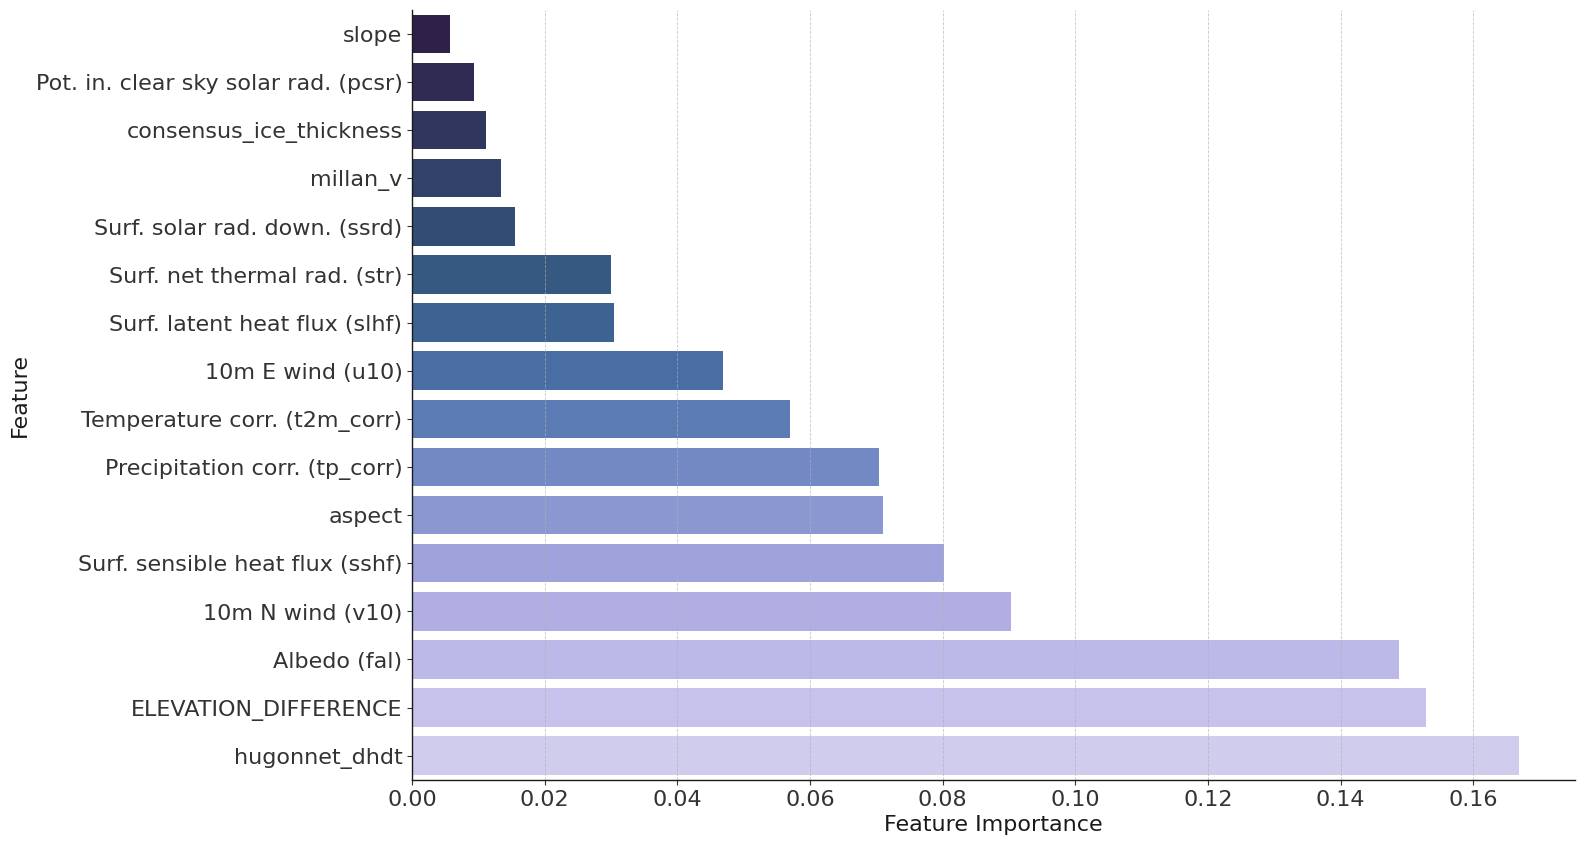

In [38]:
FIPlot(custom_model, feature_columns, vois_climate)

### Simple model: 

In [39]:
custom_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}

RUN = False
if RUN:
    # Feature columns:
    feature_columns = ['ELEVATION_DIFFERENCE'] + list([
        't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str'
    ]) + list(['aspect', 'slope', 'hugonnet_dhdt']) + ['pcsr']
    all_columns = feature_columns + config.META_DATA + config.NOT_METADATA_NOT_FEATURES
    df_X_train_subset = train_set['df_X'][all_columns]
    print('Shape of training dataset:', df_X_train_subset.shape)
    print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
    print('Running with features:', feature_columns)

    params = {**param_init, **custom_params}
    print(params)
    simple_model = mbm.models.CustomXGBoostRegressor(**params)

    # Fit on train data:
    simple_model.fit(train_set['df_X'][all_columns], train_set['y'])

    # Make predictions on test
    simple_model = simple_model.set_params(device='cpu')
    features_test, metadata_test = simple_model._create_features_metadata(
        test_set['df_X'][all_columns], config.META_DATA)
    y_pred = simple_model.predict(features_test)
    print('Shape of the test:', features_test.shape)

    # Make predictions aggr to meas ID:
    y_pred_agg = simple_model.aggrPredict(metadata_test, config.META_DATA,
                                          features_test)

    # Calculate scores
    score = simple_model.score(test_set['df_X'][all_columns],
                               test_set['y'])  # negative
    print('Overall score:', np.abs(score))

    grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
    PlotPredictions(grouped_ids, y_pred, metadata_test, test_set, simple_model)
    plt.suptitle(f'XGBoost tested on {test_glaciers}', fontsize=20)
    plt.tight_layout()

## Cumulative MB:

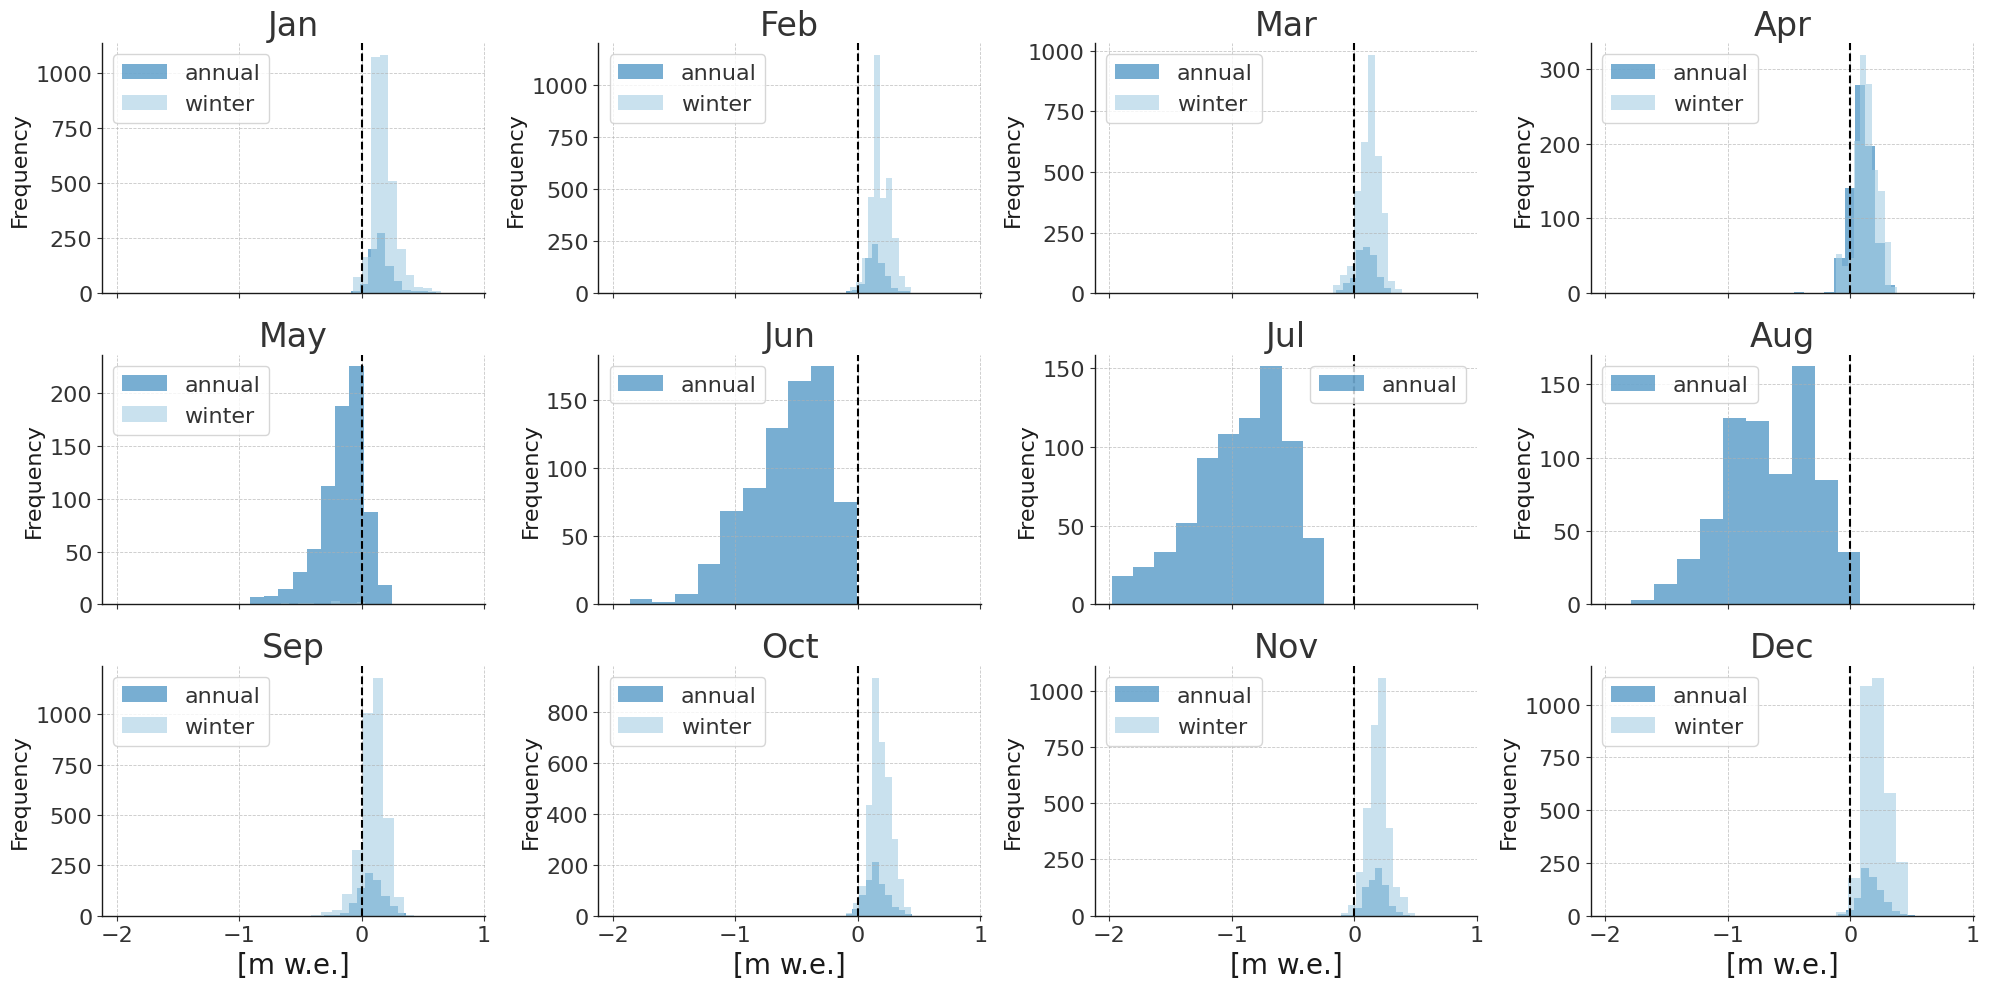

In [40]:
df_metadata = pd.DataFrame(metadata_test, columns=config.META_DATA)
df_metadata = df_metadata.assign(y_pred=y_pred)

# separate into annual and winter
dfpred_annual = df_metadata[df_metadata['PERIOD'] == 'annual']
dfpred_winter = df_metadata[df_metadata['PERIOD'] == 'winter']

# plot distribution of predictions per month, one plot per month
f, ax = plt.subplots(3, 4, figsize=(20, 10), sharex=True)
for i, month in enumerate(month_abbr[1:]):
    dfpred_annual[dfpred_annual['MONTHS'] == month.lower()].y_pred.plot.hist(
        ax=ax.flatten()[i],
        color=color_annual,
        alpha=0.6,
        density=False,
        label='annual')
    if month.lower() in dfpred_winter.MONTHS.unique():
        dfpred_winter[dfpred_winter['MONTHS'] ==
                      month.lower()].y_pred.plot.hist(ax=ax.flatten()[i],
                                                      color=color_winter,
                                                      alpha=0.6,
                                                      density=False,
                                                      label='winter')
    ax.flatten()[i].set_title(month, fontsize=24)
    ax.flatten()[i].set_xlabel('[m w.e.]', fontsize=20)
    ax.flatten()[i].legend(fontsize=16)
    # add vertical line for 0 balance
    ax.flatten()[i].axvline(x=0, color='black', linestyle='--')
plt.tight_layout()

In [41]:
# group ID to YEAR
ids_year_dict = test_set['df_X'][[
    'ID', 'YEAR'
]].groupby('ID')['YEAR'].unique().apply(list).to_dict()
ids_year_dict = {
    k: v[0] if len(v) == 1 else v
    for k, v in ids_year_dict.items()
}

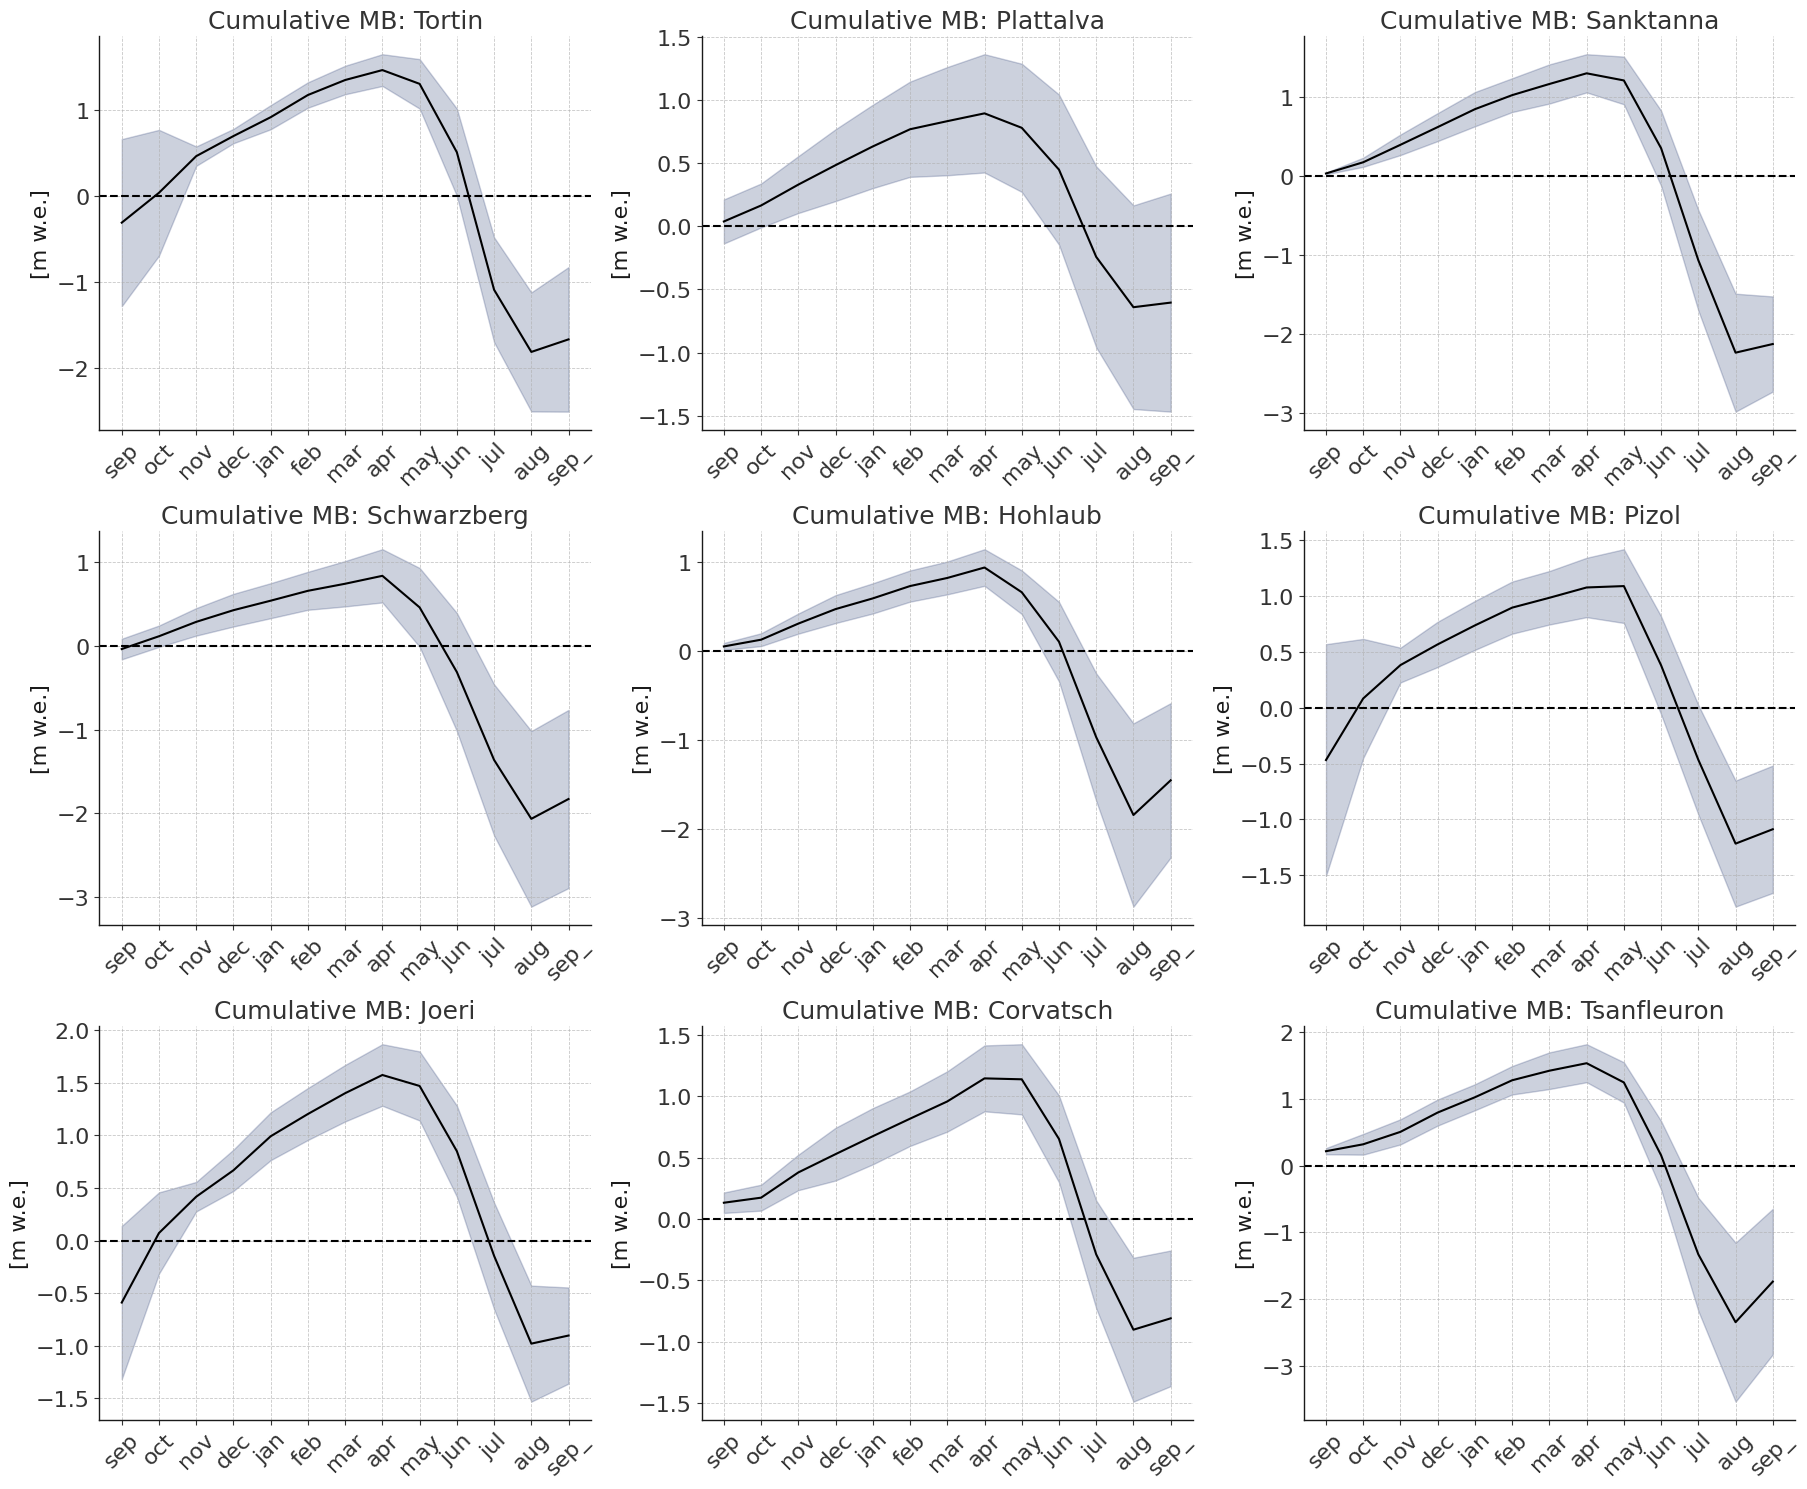

In [42]:
# Plot mean and std
fig, axs = plt.subplots(3, 3, figsize=(18, 15))
for i, test_gl in enumerate(test_glaciers):
    dfCumMB_all = cumulativeMB(dfpred_annual, test_gl, ids_year_dict)

    meanMB = pd.DataFrame(
        dfCumMB_all.groupby('months').cum_MB.mean()).reset_index()
    stdMB = pd.DataFrame(
        dfCumMB_all.groupby('months').cum_MB.std()).reset_index()

    meanMB['monthNb'] = meanMB['months'].apply(
        lambda x: month_abbr_hydr_full[x])
    stdMB['monthNb'] = stdMB['months'].apply(lambda x: month_abbr_hydr_full[x])
    # sort both by their monthNB
    meanMB = meanMB.sort_values(by='monthNb')
    stdMB = stdMB.sort_values(by='monthNb')

    ax = axs.flatten()[i]
    ax.plot(meanMB['months'].values, meanMB['cum_MB'], color='black')
    ax.fill_between(meanMB['months'].values,
                    meanMB['cum_MB'] - stdMB['cum_MB'],
                    meanMB['cum_MB'] + stdMB['cum_MB'],
                    color=color_xgb,
                    alpha=0.2)
    ax.set_title(f'Cumulative MB: {test_gl.capitalize()}')
    ax.set_ylabel('[m w.e.]')
    # add horizontal line for 0 balance
    ax.axhline(y=0, color='black', linestyle='--')
    # rotate xticks
    ax.set_xticklabels(meanMB.months, rotation=45)
plt.tight_layout()

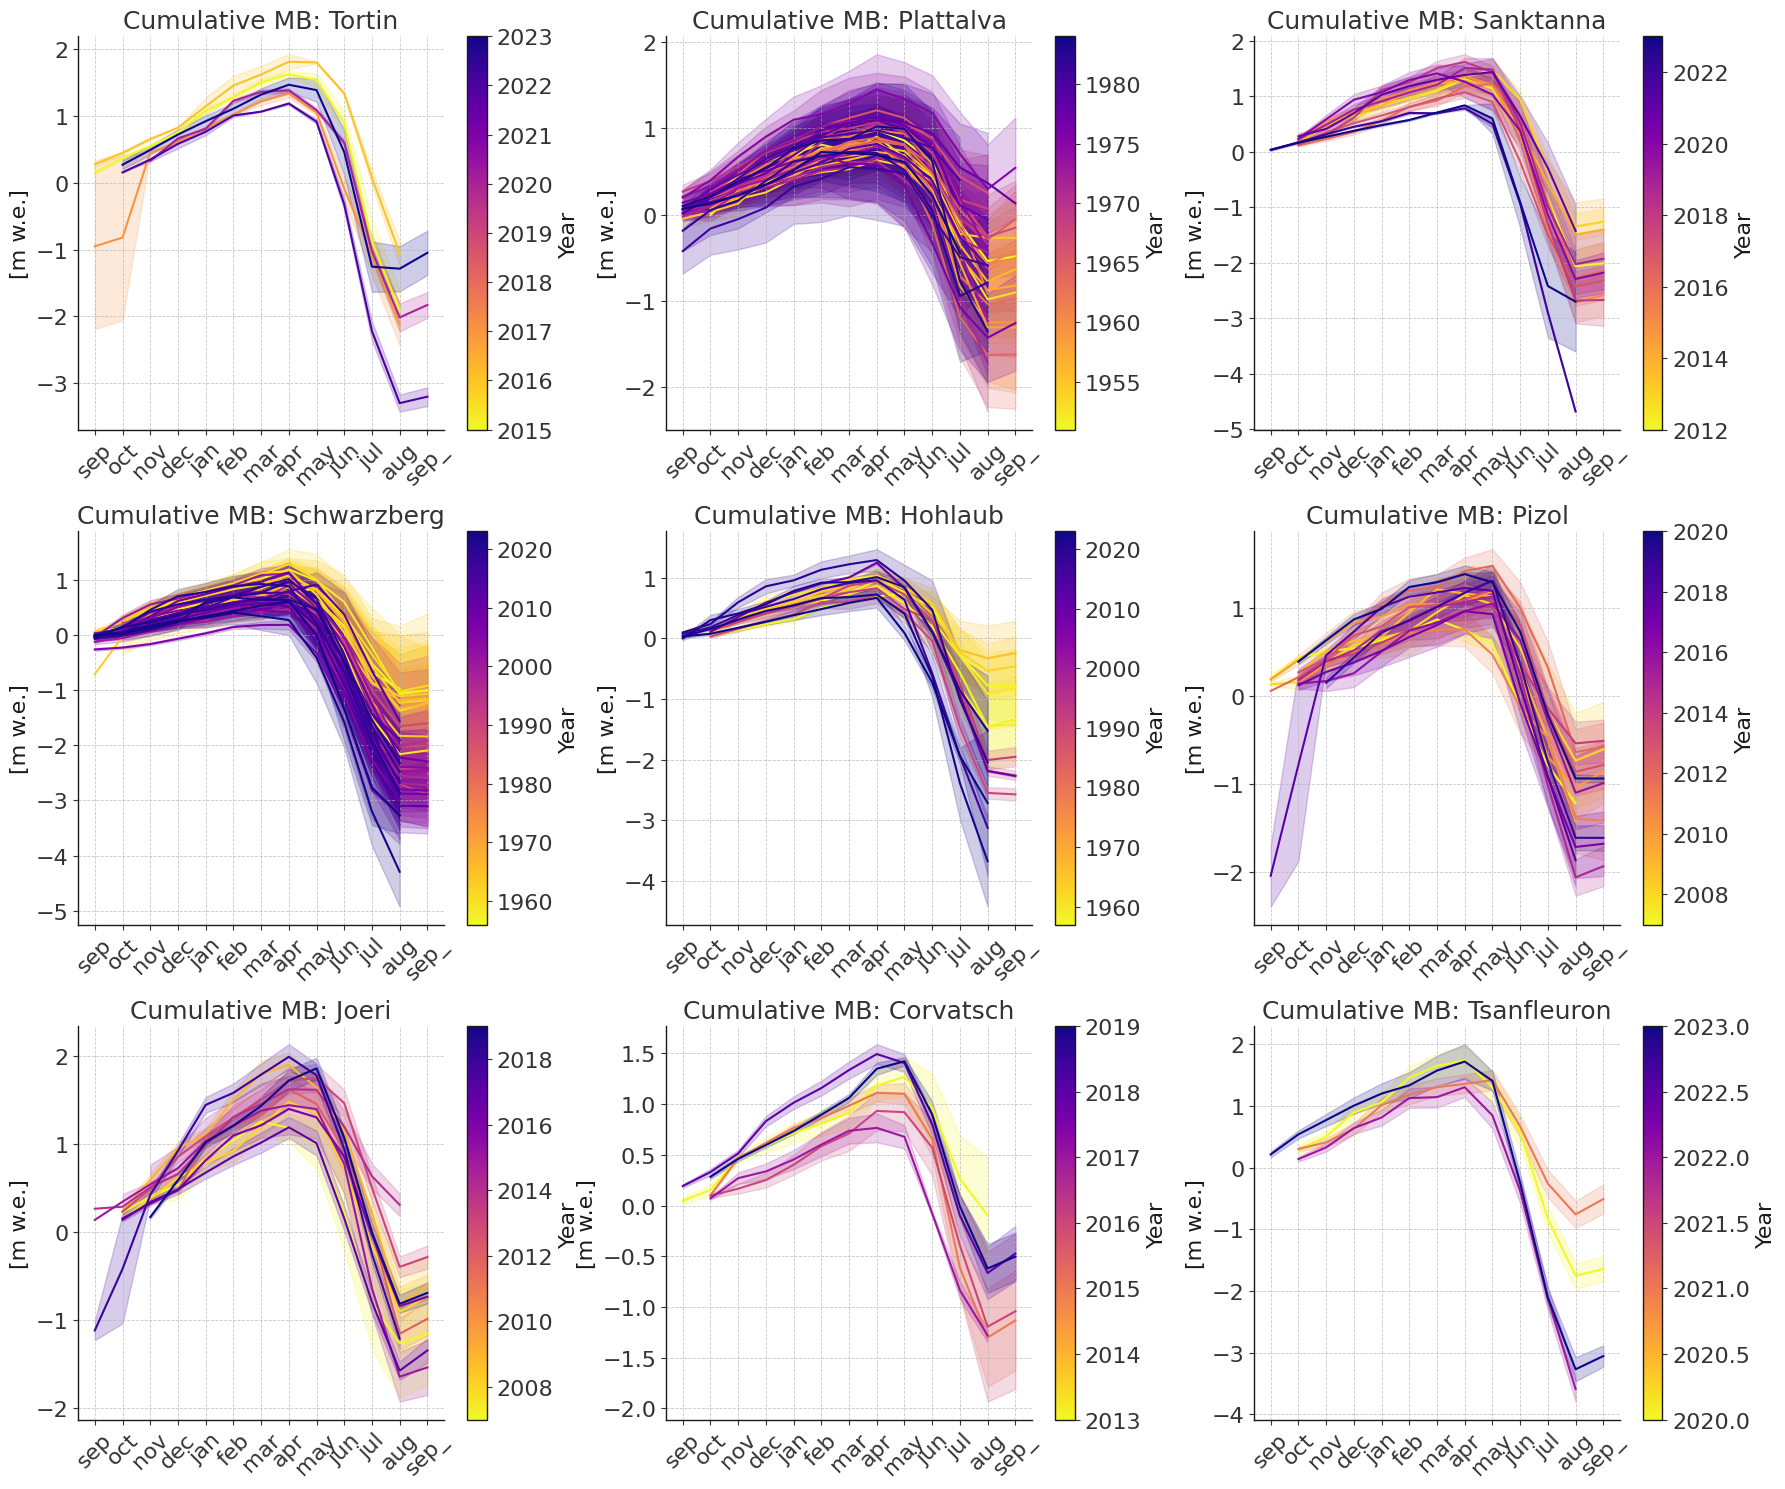

In [43]:
cmap = plt.cm.plasma_r

fig, axs = plt.subplots(3, 3, figsize=(18, 15))
for i, test_gl in enumerate(test_glaciers):
    ax = axs.flatten()[i]

    dfCumMB = cumulativeMB(dfpred_annual, test_gl, ids_year_dict)

    norm = plt.Normalize(dfCumMB['year'].min(), dfCumMB['year'].max())

    for year in dfCumMB['year'].unique():
        dfCumMB_year = dfCumMB[dfCumMB.year == year]

        meanMB = pd.DataFrame(
            dfCumMB_year.groupby('months').cum_MB.mean()).reset_index()
        stdMB = pd.DataFrame(
            dfCumMB_year.groupby('months').cum_MB.std()).reset_index()

        meanMB['monthNb'] = meanMB['months'].apply(
            lambda x: month_abbr_hydr_full[x])
        stdMB['monthNb'] = stdMB['months'].apply(
            lambda x: month_abbr_hydr_full[x])
        # sort both by their monthNB
        meanMB = meanMB.sort_values(by='monthNb')
        stdMB = stdMB.sort_values(by='monthNb')

        color = cmap(norm(year))
        ax.plot(meanMB['months'], meanMB['cum_MB'], color=color, label=year)
        ax.fill_between(meanMB['months'],
                        meanMB['cum_MB'] - stdMB['cum_MB'],
                        meanMB['cum_MB'] + stdMB['cum_MB'],
                        color=color,
                        alpha=0.2)

    # rotate xticks
    ax.set_xticklabels(month_abbr_hydr_full.keys(), rotation=45)

    ax.set_title(f'Cumulative MB: {test_gl.capitalize()}')
    ax.set_ylabel('[m w.e.]')

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Only needed for colorbar to work
    cbar = fig.colorbar(
        sm, ax=ax)  # Attach the colorbar to the figure and the specific axis
    cbar.set_label('Year')

plt.tight_layout()

## Extrapolate in space


### All glaciers: 
Compute 2D fields to compare wtih years that have Sentinel data.

In [44]:
! ls '../../../data/GLAMOS/glacier-wide/grid/'

adler_grid.csv	      gorner_grid.csv	    plattalva_grid.csv
albigna_grid.csv      gries_grid.csv	    rhone_grid.csv
aletsch_grid.csv      hohlaub_grid.csv	    sanktanna_grid.csv
allalin_grid.csv      joeri_grid.csv	    schwarzbach_grid.csv
basodino_grid.csv     limmern_grid.csv	    schwarzberg_grid.csv
claridenL_grid.csv    morteratsch_grid.csv  sexrouge_grid.csv
claridenU_grid.csv    murtel_grid.csv	    silvretta_grid.csv
corbassiere_grid.csv  oberaar_grid.csv	    taelliboden_grid.csv
corvatsch_grid.csv    otemma_grid.csv	    tortin_grid.csv
findelen_grid.csv     pers_grid.csv	    tsanfleuron_grid.csv
forno_grid.csv	      pizol_grid.csv
gietro_grid.csv       plainemorte_grid.csv


In [49]:
glaciers = [
    re.split('_grid.csv', f)[0]
    for f in os.listdir('../../../data/GLAMOS/glacier-wide/grid/')
]
satellite_years = [2015, 2016, 2017, 2018, 2019, 2020, 2021]
satellite_glaciers = ['adler', 'aletsch', 'allalin', 'basodino', 'claridenL',
       'claridenU', 'findelen', 'gries', 'hohlaub', 'limmern', 'oberaar',
       'plattalva', 'rhone', 'sanktanna', 'schwarzbach', 'schwarzberg']

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
all_columns = feature_columns + config.META_DATA + config.NOT_METADATA_NOT_FEATURES

RUN = True
if RUN:
    # glaciers = ['aletsch']
    #for glacierName in tqdm(glaciers, desc='Glaciers', position=0):
    for glacierName in tqdm(satellite_glaciers, desc='Glaciers', position=0):
        print(f'----------------------\nProcessing glacier: {glacierName}')
        # Get stake measurements for the glacier
        rgi_gl = rgi_df.loc[glacierName]['rgi_id.v6']
        data_gl = data_glamos[data_glamos.RGIId == rgi_gl]
        dataset_gl = mbm.Dataset(data=data_gl,
                                 region_name='CH',
                                 data_path=path_PMB_GLAMOS_csv)

        # Get OGGM glacier mask and grid
        ds, glacier_indices, gdir = dataset_gl.get_glacier_mask(
            custom_working_dir)

        # Create pandas dataframe of glacier grid
        years = data_gl['YEAR'].unique()
        df_grid_annual = dataset_gl.create_glacier_grid(custom_working_dir)

        # Add metadata that is not in WGMS dataset
        df_grid_annual["PERIOD"] = "annual"
        df_grid_annual['GLACIER'] = glacierName

        # Get glacier grid (preprocessed):
        df_grid_monthly = pd.read_csv(path_glacier_grid +
                                      f'{glacierName}_grid.csv')
        df_grid_monthly['GLACIER'] = glacierName
        df_grid_monthly['POINT_ELEVATION'] = df_grid_monthly['topo']
        df_grid_monthly = correctTP(
            df_grid_monthly, c_prec, t_off)  # Correct T & P for altitude
        df_grid_monthly.drop_duplicates(inplace=True)  # remove duplicates
        df_grid_monthly = df_grid_monthly[all_columns]

        # Add cumulative monthly SMB:
        df_grid_monthly = cumulativeMonthly(df_grid_monthly, custom_model)

        dataloader = mbm.DataLoader(data=df_grid_monthly,
                                    meta_data_columns=config.META_DATA)
        print('\nNumber of years: {}, from {} to {}'.format(
            len(years), years[0], years[-1]))
        print('\nNumber of total (yearly) measurements:', len(df_grid_annual))

        # get years with stake measurements:
        years_stakes = data_gl['YEAR'].unique()
        print('Years with stake measurements:', years_stakes)

        # Make glacier wide predictions over grid:
        grouped_ids_annual = GlacierWidePred(custom_model,
                                             glacierName,
                                             vois_climate,
                                             vois_topographical,
                                             c_prec, t_off,
                                             type_pred='annual')
        grouped_ids_winter = GlacierWidePred(custom_model,
                                             glacierName,
                                             vois_climate,
                                             vois_topographical,
                                             c_prec, t_off,
                                             type_pred='winter')

        # Save to netcdf for mapping:
        # save grids:
        # path_lv95 = f"results/nc/var_corr/{glacierName}/lv95/"  # Swiss coordinate system
        # path_wgs84 = f"results/nc/var_corr/{glacierName}/wgs84/"  # Laton coordinate system
        path_lv95 = f"results/nc/var_normal/{glacierName}/lv95/"  # Swiss coordinate system
        path_wgs84 = f"results/nc/var_normal/{glacierName}/wgs84/"  # Laton coordinate system

        emptyfolder(path_lv95)
        emptyfolder(path_wgs84)

        for year in tqdm(satellite_years,
                         desc='Years',
                         leave=False,
                         position=1):
            # Annual SMB:
            pred_y_annual = grouped_ids_annual[grouped_ids_annual.YEAR ==
                                               year].drop(['YEAR'], axis=1)

            ds_pred_annual_latlon, ds_pred_annual_xy = predXarray(
                ds, gdir, pred_y_annual)
            save_to_netcdf(ds_pred_annual_latlon, path_wgs84,
                           f"{glacierName}_{year}.nc")
            save_to_netcdf(ds_pred_annual_xy, path_lv95,
                           f"{glacierName}_{year}.nc")

            # Winter SMB:
            pred_y_winter = grouped_ids_winter[grouped_ids_winter.YEAR ==
                                               year].drop(['YEAR'], axis=1)
            ds_pred_winter_latlon, ds_pred_winter_xy = predXarray(
                ds, gdir, pred_y_winter)
            save_to_netcdf(ds_pred_winter_latlon, path_wgs84,
                           f"{glacierName}_{year}_w.nc")
            save_to_netcdf(ds_pred_winter_xy, path_lv95,
                           f"{glacierName}_{year}_w.nc")

            # Save monthly grids:
            # filter to one YEAR and glacier
            df_grid_monthly_gl_y = df_grid_monthly[
                (df_grid_monthly['GLACIER'] == glacierName)
                & (df_grid_monthly['YEAR'] == year)]

            for i, month in enumerate(month_abbr_hydr.keys()):
                if month == 'sep_':
                    continue
                monthNb = month_abbr_hydr[month]
                df_grid_gl_m = df_grid_monthly_gl_y[
                    df_grid_monthly_gl_y['MONTHS'] == month]

                # Get in format for map:
                df_grid_gl_m = df_grid_gl_m.groupby('ID').agg({
                    'YEAR':
                    'mean',
                    'POINT_LAT':
                    'mean',
                    'POINT_LON':
                    'mean',
                    'pred':
                    'mean',
                    'cum_pred':
                    'mean'
                })
                pred_y = df_grid_gl_m.drop(['YEAR'], axis=1)
                ds_pred_latlon, ds_pred_xy = predXarray(ds,
                                                        gdir,
                                                        pred_y,
                                                        pred_var='cum_pred')
                ds_pred_latlon = GaussianFilter(ds_pred_latlon, sigma=0.5)

                # save grids
                save_to_netcdf(ds_pred_xy, path_lv95,
                               f"{glacierName}_{year}_{monthNb}.nc")
                save_to_netcdf(ds_pred_latlon, path_wgs84,
                               f"{glacierName}_{year}_{monthNb}.nc")

Glaciers:   0%|          | 0/16 [00:00<?, ?it/s]

2024-12-10 14:39:17: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 14:39:17: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 14:39:17: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 14:39:17: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 14:39:17: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 14:39:17: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 14:39:17: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 14:39:17: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


----------------------
Processing glacier: adler


2024-12-10 14:39:18: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers
2024-12-10 14:39:18: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 14:39:18: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 14:39:18: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 14:39:18: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 14:39:18: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 14:39:18: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 14:39:18: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 14:39:18: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-12-10 14:39:18: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers



Number of years: 18, from 2006 to 2023

Number of total (yearly) measurements: 170928
Years with stake measurements: [2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
 2020 2021 2022 2023]


Years:   0%|          | 0/7 [00:00<?, ?it/s]

2024-12-10 14:41:40: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 14:41:40: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 14:41:40: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 14:41:40: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 14:41:40: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 14:41:40: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


----------------------
Processing glacier: aletsch


2024-12-10 14:41:40: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 14:41:40: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-12-10 14:41:40: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers
2024-12-10 14:41:41: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 14:41:41: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 14:41:41: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 14:41:41: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 14:41:41: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 14:41:41: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 14:41:41: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 14:41:41: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-1


Number of years: 51, from 1951 to 2023

Number of total (yearly) measurements: 315288
Years with stake measurements: [1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964
 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978
 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1997
 1998 1999 2002 2003 2004 2020 2021 2022 2023]


Years:   0%|          | 0/7 [00:00<?, ?it/s]

2024-12-10 14:45:55: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 14:45:55: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 14:45:55: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 14:45:55: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 14:45:55: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 14:45:55: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 14:45:55: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 14:45:55: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


----------------------
Processing glacier: allalin


2024-12-10 14:45:55: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers
2024-12-10 14:45:55: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 14:45:55: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 14:45:55: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 14:45:55: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 14:45:55: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 14:45:55: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 14:45:55: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 14:45:55: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-12-10 14:45:55: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers



Number of years: 68, from 1956 to 2023

Number of total (yearly) measurements: 238032
Years with stake measurements: [1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969
 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983
 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997
 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]


Years:   0%|          | 0/7 [00:00<?, ?it/s]

2024-12-10 14:49:05: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 14:49:05: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 14:49:05: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 14:49:05: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 14:49:05: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 14:49:05: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 14:49:05: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 14:49:05: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


----------------------
Processing glacier: basodino


2024-12-10 14:49:06: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers
2024-12-10 14:49:06: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 14:49:06: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 14:49:06: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 14:49:06: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 14:49:06: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 14:49:06: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 14:49:06: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 14:49:06: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-12-10 14:49:06: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers



Number of years: 32, from 1992 to 2023

Number of total (yearly) measurements: 167256
Years with stake measurements: [1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
 2020 2021 2022 2023]


Years:   0%|          | 0/7 [00:00<?, ?it/s]

2024-12-10 14:51:18: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 14:51:18: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 14:51:18: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 14:51:18: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 14:51:18: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 14:51:18: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 14:51:18: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 14:51:18: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


----------------------
Processing glacier: claridenL


2024-12-10 14:51:19: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers
2024-12-10 14:51:19: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 14:51:19: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 14:51:19: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 14:51:19: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 14:51:19: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 14:51:19: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 14:51:19: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 14:51:19: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-12-10 14:51:19: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers



Number of years: 65, from 1951 to 2023

Number of total (yearly) measurements: 107496
Years with stake measurements: [1951 1952 1953 1954 1955 1956 1958 1959 1961 1963 1964 1965 1966 1968
 1969 1970 1971 1972 1973 1974 1976 1977 1978 1981 1982 1983 1984 1985
 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999
 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016 2017 2018 2019 2020 2021 2022 2023]


Years:   0%|          | 0/7 [00:00<?, ?it/s]

2024-12-10 14:52:47: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 14:52:47: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 14:52:47: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 14:52:47: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 14:52:47: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 14:52:47: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


----------------------
Processing glacier: claridenU


2024-12-10 14:52:48: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 14:52:48: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-12-10 14:52:48: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers
2024-12-10 14:52:48: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 14:52:48: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 14:52:48: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 14:52:48: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 14:52:48: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 14:52:48: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 14:52:48: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 14:52:48: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-1


Number of years: 18, from 1951 to 2023

Number of total (yearly) measurements: 168552
Years with stake measurements: [1951 1952 1953 1954 1955 1956 1957 1960 1961 1977 1998 2001 2003 2011
 2018 2020 2021 2023]


Years:   0%|          | 0/7 [00:00<?, ?it/s]

2024-12-10 14:55:04: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 14:55:04: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 14:55:04: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 14:55:04: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 14:55:04: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 14:55:04: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 14:55:04: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 14:55:04: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


----------------------
Processing glacier: findelen


2024-12-10 14:55:04: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers
2024-12-10 14:55:04: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 14:55:04: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 14:55:04: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 14:55:04: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 14:55:04: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 14:55:04: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 14:55:05: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 14:55:05: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-12-10 14:55:05: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers



Number of years: 19, from 2005 to 2023

Number of total (yearly) measurements: 259560
Years with stake measurements: [2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2020 2021 2022 2023]


Years:   0%|          | 0/7 [00:00<?, ?it/s]

2024-12-10 14:58:35: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 14:58:35: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 14:58:35: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 14:58:35: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 14:58:35: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 14:58:35: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 14:58:35: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 14:58:35: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


----------------------
Processing glacier: gries


2024-12-10 14:58:35: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers
2024-12-10 14:58:36: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 14:58:36: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 14:58:36: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 14:58:36: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 14:58:36: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 14:58:36: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 14:58:36: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 14:58:36: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-12-10 14:58:36: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers



Number of years: 62, from 1962 to 2023

Number of total (yearly) measurements: 216000
Years with stake measurements: [1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975
 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989
 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020 2021 2022 2023]


Years:   0%|          | 0/7 [00:00<?, ?it/s]

2024-12-10 15:01:32: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 15:01:32: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 15:01:32: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 15:01:32: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 15:01:32: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 15:01:32: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 15:01:33: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 15:01:33: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


----------------------
Processing glacier: hohlaub


2024-12-10 15:01:33: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers
2024-12-10 15:01:33: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 15:01:33: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 15:01:33: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 15:01:33: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 15:01:33: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 15:01:33: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 15:01:33: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 15:01:33: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-12-10 15:01:33: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers



Number of years: 36, from 1957 to 2023

Number of total (yearly) measurements: 163080
Years with stake measurements: [1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1973 1974 1975
 1976 1977 1978 1980 1981 1982 1983 1984 1985 1986 1987 1988 1990 1991
 1992 1995 2009 2017 2020 2021 2022 2023]


Years:   0%|          | 0/7 [00:00<?, ?it/s]

2024-12-10 15:03:45: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 15:03:45: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 15:03:45: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 15:03:45: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 15:03:45: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 15:03:45: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


----------------------
Processing glacier: limmern


2024-12-10 15:03:45: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 15:03:45: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-12-10 15:03:46: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers
2024-12-10 15:03:46: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 15:03:46: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 15:03:46: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 15:03:46: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 15:03:46: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 15:03:46: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 15:03:46: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 15:03:46: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-1


Number of years: 33, from 1951 to 1985

Number of total (yearly) measurements: 160920
Years with stake measurements: [1951 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966
 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980
 1981 1982 1983 1984 1985]


Years:   0%|          | 0/7 [00:00<?, ?it/s]

2024-12-10 15:06:01: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 15:06:01: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 15:06:01: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 15:06:01: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 15:06:01: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 15:06:01: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 15:06:01: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 15:06:01: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


----------------------
Processing glacier: oberaar


2024-12-10 15:06:01: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers
2024-12-10 15:06:01: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 15:06:01: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 15:06:01: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 15:06:01: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 15:06:01: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 15:06:01: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 15:06:01: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 15:06:01: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-12-10 15:06:01: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers



Number of years: 2, from 2003 to 2023

Number of total (yearly) measurements: 205776
Years with stake measurements: [2003 2023]


Years:   0%|          | 0/7 [00:00<?, ?it/s]

2024-12-10 15:08:46: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 15:08:46: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 15:08:46: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 15:08:46: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 15:08:46: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 15:08:46: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 15:08:46: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 15:08:46: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


----------------------
Processing glacier: plattalva


2024-12-10 15:08:47: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers
2024-12-10 15:08:47: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 15:08:47: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 15:08:47: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 15:08:47: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 15:08:47: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 15:08:47: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 15:08:47: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 15:08:47: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-12-10 15:08:47: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers



Number of years: 34, from 1951 to 1985

Number of total (yearly) measurements: 83592
Years with stake measurements: [1951 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965
 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979
 1980 1981 1982 1983 1984 1985]


Years:   0%|          | 0/7 [00:00<?, ?it/s]

2024-12-10 15:10:03: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 15:10:03: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 15:10:03: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 15:10:03: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 15:10:03: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 15:10:03: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 15:10:03: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 15:10:03: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


----------------------
Processing glacier: rhone


2024-12-10 15:10:03: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers
2024-12-10 15:10:03: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 15:10:03: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 15:10:03: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 15:10:03: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 15:10:03: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 15:10:03: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 15:10:04: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 15:10:04: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-12-10 15:10:04: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers



Number of years: 20, from 1980 to 2023

Number of total (yearly) measurements: 262080
Years with stake measurements: [1980 1981 1982 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020 2021 2022 2023]


Years:   0%|          | 0/7 [00:00<?, ?it/s]

2024-12-10 15:14:05: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 15:14:05: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 15:14:05: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 15:14:05: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 15:14:05: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 15:14:05: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


----------------------
Processing glacier: sanktanna


2024-12-10 15:14:06: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 15:14:06: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-12-10 15:14:06: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers
2024-12-10 15:14:06: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 15:14:06: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 15:14:06: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 15:14:06: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 15:14:06: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 15:14:06: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 15:14:06: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 15:14:06: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-1


Number of years: 12, from 2012 to 2023

Number of total (yearly) measurements: 58752
Years with stake measurements: [2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]


Years:   0%|          | 0/7 [00:00<?, ?it/s]

2024-12-10 15:14:59: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 15:14:59: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 15:14:59: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 15:14:59: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 15:14:59: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 15:14:59: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 15:14:59: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 15:14:59: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


----------------------
Processing glacier: schwarzbach


2024-12-10 15:14:59: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers
2024-12-10 15:14:59: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 15:14:59: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 15:14:59: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 15:14:59: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 15:14:59: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 15:14:59: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 15:14:59: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 15:14:59: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-12-10 15:14:59: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers



Number of years: 11, from 2012 to 2022

Number of total (yearly) measurements: 23760
Years with stake measurements: [2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]


Years:   0%|          | 0/7 [00:00<?, ?it/s]

2024-12-10 15:15:24: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 15:15:24: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 15:15:24: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 15:15:24: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 15:15:24: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 15:15:24: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 15:15:25: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 15:15:25: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


----------------------
Processing glacier: schwarzberg


2024-12-10 15:15:25: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers
2024-12-10 15:15:25: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 15:15:25: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 15:15:25: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 15:15:25: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 15:15:25: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 15:15:25: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 15:15:25: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 15:15:25: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-12-10 15:15:25: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers



Number of years: 40, from 1956 to 2023

Number of total (yearly) measurements: 218304
Years with stake measurements: [1956 1957 1958 1959 1960 1961 1962 1963 1964 1966 1967 1989 1990 1991
 1992 1995 1996 1997 1999 2000 2001 2002 2004 2005 2006 2007 2008 2009
 2010 2011 2012 2013 2014 2017 2018 2019 2020 2021 2022 2023]


Years:   0%|          | 0/7 [00:00<?, ?it/s]

### One glacier example:

In [56]:
# vois_climate = [
#     't2m', 'tp', 't2m_corr', 'tp_corr', 'slhf', 'sshf', 'ssrd', 'fal', 'str',
#     'u10', 'v10'
# ]

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
all_columns = feature_columns + config.META_DATA + config.NOT_METADATA_NOT_FEATURES

# Make glacier wide predictions for one test glacier:
glacierName = 'aletsch'

rgi_gl = rgi_df.loc[glacierName]['rgi_id.v6']
data_gl = data_glamos[data_glamos.RGIId == rgi_gl]
dataset_gl = mbm.Dataset(data=data_gl,
                         region_name='CH',
                         data_path=path_PMB_GLAMOS_csv)
ds, glacier_indices, gdir = dataset_gl.get_glacier_mask(custom_working_dir)

# Create pandas dataframe of glacier grid
years = data_gl['YEAR'].unique()
df_grid_annual = dataset_gl.create_glacier_grid(custom_working_dir)
# Add metadata that is not in WGMS dataset
df_grid_annual["PERIOD"] = "annual"
df_grid_annual['GLACIER'] = glacierName

# Get glacier grid (preprocessed):
df_grid_monthly = pd.read_csv(path_glacier_grid + f'{glacierName}_grid.csv')
df_grid_monthly['GLACIER'] = glacierName
df_grid_monthly['POINT_ELEVATION'] = df_grid_monthly['topo']
df_grid_monthly = correctTP(df_grid_monthly, c_prec, t_off)  # Correct T & P for altitude
df_grid_monthly.drop_duplicates(inplace=True)  # remove duplicates
df_grid_monthly = df_grid_monthly[all_columns]

# Add cumulative monthly SMB:
df_grid_monthly = cumulativeMonthly(df_grid_monthly, custom_model)

dataloader = mbm.DataLoader(data=df_grid_monthly,
                            meta_data_columns=config.META_DATA)
print('\nNumber of years: {}, from {} to {}'.format(len(years), years[0],
                                                    years[-1]))
print('\nNumber of total (yearly) measurements:', len(df_grid_annual))

# get years with stake measurements:
years_stakes = data_gl['YEAR'].unique()
print('Years with stake measurements:', years_stakes)

# Plot glacier attributes of oggm:
plotGlAttr(ds, cmap=cm.devon)

# Plot glacier grid with stakes:
plotGlGrid(df_grid_annual, data_gl)

2024-12-10 12:42:42: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 12:42:42: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-12-10 12:42:42: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-12-10 12:42:42: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-12-10 12:42:42: oggm.cfg: Multiprocessing switched ON after user settings.
2024-12-10 12:42:42: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-12-10 12:42:42: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-12-10 12:42:42: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-12-10 12:42:42: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers
2024-12-10 12:42:43: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-12-10 12:42:43: oggm.cfg: Multiprocessing switched OFF according to the parameter 

KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(18, 15))
for var in vois_climate:
    ax = axs.flatten()[vois_climate.index(var)]
    var_df = df_grid_monthly[(df_grid_monthly.YEAR == 2021)
                             & (df_grid_monthly.MONTHS == 'aug')][[
                                 'POINT_LON', 'POINT_LAT', var
                             ]]
    sns.scatterplot(data=var_df,
                    x='POINT_LON',
                    y='POINT_LAT',
                    hue=var,
                    s=4,
                    palette='coolwarm',
                    ax=ax)
    # remove legend
    # ax.get_legend().remove()
    ax.set_title(vois_climate_long_name[var] + ' August 2021')
plt.tight_layout()

In [ ]:
# Annual and winter seasonal predictions:
grouped_ids_annual = GlacierWidePred(custom_model,
                                     glacierName,
                                     vois_climate,
                                     vois_topographical,
                                     type_pred='annual')
grouped_ids_winter = GlacierWidePred(custom_model,
                                     glacierName,
                                     vois_climate,
                                     vois_topographical,
                                     type_pred='winter')

#### Glacier wide vs GLAMOS:

In [ ]:
# Sum over all points of a glacier to get glacier wide SMB
grouped_ids_annual_glw = grouped_ids_annual.groupby('YEAR').mean()

# Compare to GLAMOS data:
if 'clariden' in glacierName:
    df_glamos = pd.read_csv(path_SMB_GLAMOS_csv + 'fix/' + f'clariden_fix.csv')
else:
    df_glamos = pd.read_csv(path_SMB_GLAMOS_csv + 'fix/' +
                            f'{glacierName}_fix.csv')
df_glamos = transformDates(df_glamos)

# Remove obvious duplicates:
df_glamos = df_glamos.drop_duplicates()
df_glamos['YEAR'] = df_glamos['date1'].apply(lambda x: pd.to_datetime(x).year)
df_glamos['Annual Balance'] = df_glamos['Annual Balance'] / (1000)
df_glamos = df_glamos[['YEAR', 'Annual Balance']].set_index('YEAR')

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
grouped_ids_annual_glw.plot(y='pred',
                            label='Predicted SMB',
                            ax=ax,
                            color=color_xgb)
df_glamos[df_glamos.index > 1960].plot(y='Annual Balance',
                                       label='GLAMOS SMB',
                                       ax=ax,
                                       color=color_tim)

ax.set_title(f'{glacierName.title()} SMB')
ax.set_ylabel('SMB (m w.e.)')
plt.tight_layout()

#### Seasonal plot:

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
TwoDPlots(ds, gdir, glacierName, grouped_ids_annual, grouped_ids_winter, 2021,
          axs)

#### Monthly:

In [ ]:
YEAR = 2021

# filter to one YEAR and glacier
df_grid_gl = df_grid_monthly[(df_grid_monthly['GLACIER'] == glacierName)
                             & (df_grid_monthly['YEAR'] == YEAR)]

vmax, vmin = [], []
for i, month in enumerate(month_abbr_hydr.keys()):
    if month == 'sep_':
        continue
    df_grid_gl_m = df_grid_gl[df_grid_gl['MONTHS'] == month]

    # Get in format for map:
    df_grid_gl_m = df_grid_gl_m.groupby('ID').agg({
        'YEAR': 'mean',
        'POINT_LAT': 'mean',
        'POINT_LON': 'mean',
        'pred': 'mean',
        'cum_pred': 'mean'
    })
    pred_y = df_grid_gl_m.drop(['YEAR'], axis=1)
    ds_pred, ds_pred_xy = predXarray(ds, gdir, pred_y)
    ds_pred = GaussianFilter(ds_pred, sigma=0.5)

    vmax.append(ds_pred.pred_masked.max().values)
    vmin.append(ds_pred.pred_masked.min().values)

vmax = max(vmax)
vmin = min(vmin)

fig, axs = plt.subplots(4, 3, figsize=(25, 20))
for i, month in enumerate(month_abbr_hydr.keys()):
    if month == 'sep_':
        continue
    df_grid_gl_m = df_grid_gl[df_grid_gl['MONTHS'] == month]
    # Get in format for map:
    df_grid_gl_m = df_grid_gl_m.groupby('ID').agg({
        'YEAR': 'mean',
        'POINT_LAT': 'mean',
        'POINT_LON': 'mean',
        'pred': 'mean',
        'cum_pred': 'mean'
    })
    pred_y = df_grid_gl_m.drop(['YEAR'], axis=1)
    ds_pred, ds_pred_xy = predXarray(ds, gdir, pred_y)
    ds_pred = GaussianFilter(ds_pred, sigma=0.5)
    ax = axs.flatten()[i]

    Plot2DPred(fig, vmin, vmax, ds_pred, YEAR, month, ax, savefig=False)

plt.tight_layout


#### Cum monthly:

In [ ]:
# filter to one YEAR and glacier
df_grid_gl = df_grid_monthly[(df_grid_monthly['GLACIER'] == glacierName)
                             & (df_grid_monthly['YEAR'] == YEAR)]

vmax, vmin = [], []
for i, month in enumerate(month_abbr_hydr.keys()):
    if month == 'sep_':
        continue
    df_grid_gl_m = df_grid_gl[df_grid_gl['MONTHS'] == month]

    # Get in format for map:
    df_grid_gl_m = df_grid_gl_m.groupby('ID').agg({
        'YEAR': 'mean',
        'POINT_LAT': 'mean',
        'POINT_LON': 'mean',
        'pred': 'mean',
        'cum_pred': 'mean'
    })
    pred_y = df_grid_gl_m.drop(['YEAR'], axis=1)
    ds_pred, ds_pred_xy = predXarray(ds, gdir, pred_y, pred_var='cum_pred')
    ds_pred = GaussianFilter(ds_pred, sigma=0.5)

    vmax.append(ds_pred.pred_masked.max().values)
    vmin.append(ds_pred.pred_masked.min().values)

vmax = max(vmax)
vmin = min(vmin)

fig, axs = plt.subplots(4, 3, figsize=(25, 20))
for i, month in enumerate(month_abbr_hydr.keys()):
    if month == 'sep_':
        continue
    df_grid_gl_m = df_grid_gl[df_grid_gl['MONTHS'] == month]
    # Get in format for map:
    df_grid_gl_m = df_grid_gl_m.groupby('ID').agg({
        'YEAR': 'mean',
        'POINT_LAT': 'mean',
        'POINT_LON': 'mean',
        'pred': 'mean',
        'cum_pred': 'mean'
    })
    pred_y = df_grid_gl_m.drop(['YEAR'], axis=1)
    ds_pred, ds_pred_xy = predXarray(ds, gdir, pred_y, pred_var='cum_pred')
    ds_pred = GaussianFilter(ds_pred, sigma=0.5)
    ax = axs.flatten()[i]

    Plot2DPred(fig, vmin, vmax, ds_pred, YEAR, month, ax, savefig=False)

plt.tight_layout


#### GIf:

In [ ]:
# for i, month in enumerate(month_abbr_hydr.keys()):
#     fig = plt.figure(figsize=(10, 10))
#     ax = fig.add_subplot(111)
#     if month == 'sep_':
#         continue
#     monthNb = month_abbr_hydr[month]
#     df_grid_gl_m = df_grid_gl[df_grid_gl['MONTHS'] == month]

#     # Get in format for map:
#     df_grid_gl_m = df_grid_gl_m.groupby('ID').agg({
#         'YEAR': 'mean',
#         'POINT_LAT': 'mean',
#         'POINT_LON': 'mean',
#         'pred': 'mean',
#         'cum_pred': 'mean'
#     })
#     pred_y = df_grid_gl_m.drop(['YEAR'], axis=1)
#     ds_pred_latlon, ds_pred_xy = predXarray(ds,
#                                             gdir,
#                                             pred_y,
#                                             pred_var='cum_pred')

#     ds_pred_latlon = GaussianFilter(ds_pred_latlon, sigma=0.5)

#     Plot2DPred(fig, vmin, vmax, ds_pred_latlon, YEAR, month, ax, savefig=True)